# Context
The project aims to enhance the indicator and critical analysis of urgent medication delivery times in a hospital, aligning it with data-driven thinking to increase operational efficiency and improve the patient experience. The initial analysis revealed significant limitations in the current method, which uses the median to assess delivery times, resulting in superficial and undetailed analyses.

To address this issue, a model was implemented that combines LightGBM and third quartile analysis with EWMA. LightGBM is used to identify the critical variables that influence the process (I made the code available to test different models according to the statistical distribution of your data), determining their importance based on the variation they cause in delivery time. These variables include order generation and delivery times, prescribing department, and the user responsible for delivery. Third quartile analysis with EWMA provides a clear view of critical times and days, enabling more informed discussions with the GEMBA team.

With this approach, data is transformed into actionable insights, promoting a continuous improvement cycle and elevating the process to analytical maturity. The indicator evolved from an initial maturity state, where only the median delivery time was measured, to an advanced state at CMMI (Capability Maturity Model Integration) levels 4/5. This new model includes critical variables, detailed statistical analysis, and the use of advanced machine learning techniques, providing a more complete and accurate view of performance and enabling more effective and proactive process management.


# Problem
The delivery time indicator was calculated manually. Daily, the coordinator pulled all deliveries into Excel and calculated the median per shift to publish a chart for the team. This method generated the following difficulties:

- Superficiality: The analysis is limited to the median delivery time, without exploring deeper variables.
- Inconsistency: Batches generated before midnight and delivered after that time result in negative values, delaying analysis.
- Delay: The daily production of the indicator consumes about 20 minutes, restricting the ability to respond quickly.


# Impact on the Company
- Operational Efficiency: Delays in analysis limit the ability to act quickly on delays.
- Patient Satisfaction: Delays directly affect the patient experience.
- Data-Driven Culture: The absence of robust analysis hinders the consolidation of data-oriented thinking.
- Resource Management: Excessive time spent on manual data generation reduces focus on strategic activities.
- Waste Elimination: Automating collection and analysis processes will allow the team to focus efforts on higher value-added activities.

# Project Timeline

This project was applied in real life and brought significant gains to the process and data-driven thinking of the team.

The project was divided into 4 phases:

## Phase 1
- 1.1. Created an automation in Python so that box plots could be plotted daily to be shared with the team.
- 1.2. The indicator was adjusted to include more relevant statistics to analyze the robustness of the process: Median of the delivery time of urgencies (per shift), percentage of items that exceeded 30 minutes, percentile 0.9 (90th percentile) of the delivery time of urgencies, the percentage of outliers (defined as Q3 + 4*IQR).


## Phase 2
- 2.1. Advanced statistical studies - KDEs, Histograms, Normality test.
- 2.2. Included comparative tests (AB, Wilcoxon) to understand if there was a statistical difference in deliveries between users and sectors.

## Phase 3
- 4.1 - Tested several models for a comparative analysis that determined the importance of each independent variable for the variation of the process.
- 4.2 - Chosen model - LightGBM - was refined and tested for discussion with the team.

## Phase 4
- Officially implemented model for the critical analysis of this indicator, which will be the gold standard and will serve as an example for the evolution of other indicators of the hospital pharmacy.


The timeline is fundamental to understanding the evolution of the process and how the maturity of the indicator was achieved progressively. Below I will present the solution in code format, adapting to the step-by-step presented by FM2S.

# 1. Import Data
- For this project, I used data exported from Tasy - a hospital management system - if you want to understand the necessary steps for cleaning and preparing the data - access the repository https://github.com/davirjr/leitura_tratamento_tasy (this project is in portuguese, you can translate if you need)
- I divided the data into 2 - Test and Validation
- The data from this project will not be disclosed (LGPD), replace it with your data to use the proposal.

In [ ]:
# @title Importar bibliotecas
!pip install ydata_profiling
!pip install catboost
!pip install dask
from datetime import date
from datetime import timedelta
from datetime import timedelta, time
import pandas as pd
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=a267aaed2e06cd61dd59bd132e3107e6287d32f5e30dea43d5c2f92a510f21aa
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# @title Primeiras tratativas e leitura dos dados

#Colunas disponíveis no dataset original
columns = ['Nr atendimento',	'Setor paciente',	'Setor prescricao',	'Ds local estoque',	'Cd material',	'Ds material',	'Nr sequencia',	'Dt prescricao',	'Dt entrega setor',	'Dt recebimento setor',	'Dt geracao lote',	'Ds classificacao',	'Dt ger lote',	'Hr ger lote',	'Dt entr setor',	'Hr entr setor',	'Usuario entrega']

# Caminho para o Arquivo
tempos_bruto = pd.read_csv('Seuarquivo.csv', delimiter=',', names=columns, dtype=tipos_dados, engine='python', encoding='utf-8', skiprows=1) # Substitua pelo seu arquivo.
tempos_bruto_validacao = pd.read_csv('Seuarquivo.csv', delimiter=',', names=columns, dtype=tipos_dados, engine='python', encoding='utf-8', skiprows=1) # Substitua pelo seu arquivo.

In [ ]:
# @title Preparo dos dados - Teste e validação.
# @markdown Faça o preparo dos seus dados para que eles demonstrem a variável dependente e as variáveis dependente. Lembre-se de calcular as metricas que são relevantes - por exemplo, nesse projeto foi o tempo de entrega.

# 2.1. - Assess Data Quality - Test Data

- No inconsistencies were found, only duplicate values that were removed.

In [ ]:
Tempos_Limpo_Urgencia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54307 entries, 27705 to 242060
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   Setor prescricao            54307 non-null  object         
 1   Cd material                 54307 non-null  object         
 2   Dt ger lote                 54307 non-null  object         
 3   Usuario entrega             54307 non-null  object         
 4   Hora de geração             54307 non-null  timedelta64[ns]
 5   Hora de Entrega             54307 non-null  timedelta64[ns]
 6   Tempo de entrega            54307 non-null  timedelta64[ns]
 7   Tempo de entrega (minutos)  54307 non-null  float64        
dtypes: float64(1), object(4), timedelta64[ns](3)
memory usage: 3.7+ MB


In [ ]:
Tempos_Limpo_Urgencia.describe()

,Hora de geração,Hora de Entrega,Tempo de entrega,Tempo de entrega (minutos)
count,54307,54307,54307,54307.000000
mean,0 days 12:34:17.081941554,0 days 12:47:14.075680851,0 days 00:31:16.343731010,31.272396
std,0 days 05:33:44.450279809,0 days 05:34:29.860932928,0 days 00:50:13.472175597,50.224536
min,0 days 00:00:01,0 days 00:00:05,0 days 00:01:53,1.883333
25%,0 days 08:41:33,0 days 09:06:18,0 days 00:18:27,18.450000
50%,0 days 11:50:36,0 days 12:08:52,0 days 00:23:52,23.866667
75%,0 days 16:39:41.500000,0 days 16:50:28,0 days 00:32:33,32.550000
max,0 days 23:59:47,0 days 23:59:43,0 days 23:08:03,1388.050000


In [ ]:
Vazio = Tempos_Limpo_Urgencia.isnull().sum()
Vazio

,0
Setor prescricao,0
Cd material,0
Dt ger lote,0
Usuario entrega,0
Hora de geração,0
Hora de Entrega,0
Tempo de entrega,0
Tempo de entrega (minutos),0


In [ ]:
duplicados = Tempos_Limpo_Urgencia.duplicated().sum()
duplicados

11

In [ ]:
Tempos_Limpo_Urgencia = Tempos_Limpo_Urgencia.drop_duplicates()

# 2.2. - Assess Data Quality - Validation Data

- No inconsistencies were found, only duplicate values that were removed.

In [ ]:
Tempos_Limpo_validacao_Urgencia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22993 entries, 603 to 84314
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   Setor prescricao            22993 non-null  object         
 1   Cd material                 22993 non-null  object         
 2   Dt ger lote                 22993 non-null  object         
 3   Usuario entrega             22993 non-null  object         
 4   Hora de geração             22993 non-null  timedelta64[ns]
 5   Hora de Entrega             22993 non-null  timedelta64[ns]
 6   Tempo de entrega            22993 non-null  timedelta64[ns]
 7   Tempo de entrega (minutos)  22993 non-null  float64        
dtypes: float64(1), object(4), timedelta64[ns](3)
memory usage: 1.6+ MB


In [ ]:
Tempos_Limpo_validacao_Urgencia.describe()

,Hora de geração,Hora de Entrega,Tempo de entrega,Tempo de entrega (minutos)
count,22993,22993,22993,22993.000000
mean,0 days 12:46:17.156264950,0 days 12:58:29.307441395,0 days 00:28:25.386508937,28.423108
std,0 days 05:41:57.878285428,0 days 05:43:52.243659882,0 days 00:40:03.094753901,40.051579
min,0 days 00:00:15,0 days 00:00:01,0 days 00:02:41,2.683333
25%,0 days 08:39:56,0 days 08:59:27,0 days 00:17:50,17.833333
50%,0 days 12:16:34,0 days 12:31:46,0 days 00:22:17,22.283333
75%,0 days 17:14:13,0 days 17:30:30,0 days 00:29:43,29.716667
max,0 days 23:59:59,0 days 23:59:57,0 days 21:52:33,1312.550000


In [ ]:
Vazio1 = Tempos_Limpo_validacao_Urgencia.isnull().sum()
Vazio1

,0
Setor prescricao,0
Cd material,0
Dt ger lote,0
Usuario entrega,0
Hora de geração,0
Hora de Entrega,0
Tempo de entrega,0
Tempo de entrega (minutos),0


In [ ]:
duplicados1 = Tempos_Limpo_validacao_Urgencia.duplicated().sum()
duplicados1

6

In [ ]:
Tempos_Limpo_validacao_Urgencia = Tempos_Limpo_validacao_Urgencia.drop_duplicates()


# 3.1.1. Evaluate the Behavior of Variables - Test Data

- The 'Boxplot without outliers' topic was used in phase 1.1 - the same code automated the daily analysis.
- The 'simple statistics' topic was used in phase 1.2 for daily discussion with the team.
- The 'Histograms and KDEs' topic was used in phase 2.1, based on this analysis the stability of the process and the statistical distribution were evaluated, identifying variations and anomalies.

In [ ]:
# @title Simples Statistics
# Calcula o número total de entregas de urgência
total_entregas = len(Tempos_Limpo_Urgencia)

# Calcula o número de entregas que passaram de 30 minutos
entregas_acima_30_minutos = len(Tempos_Limpo_Urgencia[Tempos_Limpo_Urgencia['Tempo de entrega (minutos)'] > 30])

# Calcula a porcentagem de entregas que passaram de 30 minutos
porcentagem_acima_30_minutos = (entregas_acima_30_minutos / total_entregas) * 100

# Calcula o percentil 0.9
percentil_90 = Tempos_Limpo_Urgencia['Tempo de entrega (minutos)'].quantile(0.9)

# Calcula a quantidade de Lotes Urgentes
distinct_count = Tempos_Limpo['Nr sequencia'].nunique()

# Calcular Qual é o valor que representa o terceiro quartil + 4*IQR
Q1 = Tempos_Limpo_Urgencia['Tempo de entrega (minutos)'].quantile(0.25)
Q3 = Tempos_Limpo_Urgencia['Tempo de entrega (minutos)'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 4 * IQR

# Calcular quantos % estão acima do valor Q3 + 4*IQR
percentage_above_threshold = (Tempos_Limpo_Urgencia['Tempo de entrega (minutos)'] > outlier_threshold).mean() * 100

# Calcular quantos lotes estão acima do valor Q3 + 4*IQR
percentage_above_threshold_lotes = percentage_above_threshold*distinct_count/100

# Armazenar as saídas em variáveis
mediana_com_outliers_output = f"Mediana do Tempo de entrega de urgências - Diurno e Noturno: <b>  {hours:02}:{minutes:02}:{seconds:02} </b>"
mediana_tempo_entrega_Urgencias_noturno_output = f"Mediana do Tempo de entrega (Noturno): <b> {hours_noturno:02}:{minutes_noturno:02}:{seconds_noturno:02} </b> "
mediana_tempo_entrega_Urgencias_diurno_output = f"Mediana do Tempo de entrega (Diurno): <b>  {hours_diurno:02}:{minutes_diurno:02}:{seconds_business_diurno:02} </b> "
porcentagem_output = f"A porcentagem de itens que passaram de 30 minutos é: <b> {porcentagem_acima_30_minutos:.2f}% </b> "
percentil_output = f"O percentil 0.9 (90º percentil) do tempo de entrega das urgências é: <b> {percentil_90:.2f} minutos </b> "
distinct_count_output = f'A quantidade total de Lotes Urgentes dispensados é: <b> {distinct_count} lotes </b> '
outlier_threshold_output = f'Outliers = Q3 + 4*IQR é: <b> {outlier_threshold:.2f} minutos </b> '
percentage_above_threshold_output = f'A porcentagem de outliers é: <b> {percentage_above_threshold:.2f}% </b>, que representa <b> {percentage_above_threshold_lotes:.2f} Lotes </b> '

# Criar um HTML com todos os textos em um tamanho maior (fiz isso porque os números saem muito pequenos no meu monitor - depois descobri que podia dar zoom, mas pelo menos serviu para aprender a criar esse tipo de saída)
html_output = f"""
<font size='4'>
  <p>{mediana_com_outliers_output}</p>


  <p>{mediana_tempo_entrega_Urgencias_noturno_output}</p>


  <p>{mediana_tempo_entrega_Urgencias_diurno_output}</p>


  <p>{porcentagem_output}</p>


  <p>{percentil_output}</p>


    <p>{outlier_threshold_output}</p>

    <p>{distinct_count_output}</p>

  <p>{percentage_above_threshold_output}</p>
</font>
"""

# Exibir a saída com o HTML
display(HTML(html_output))

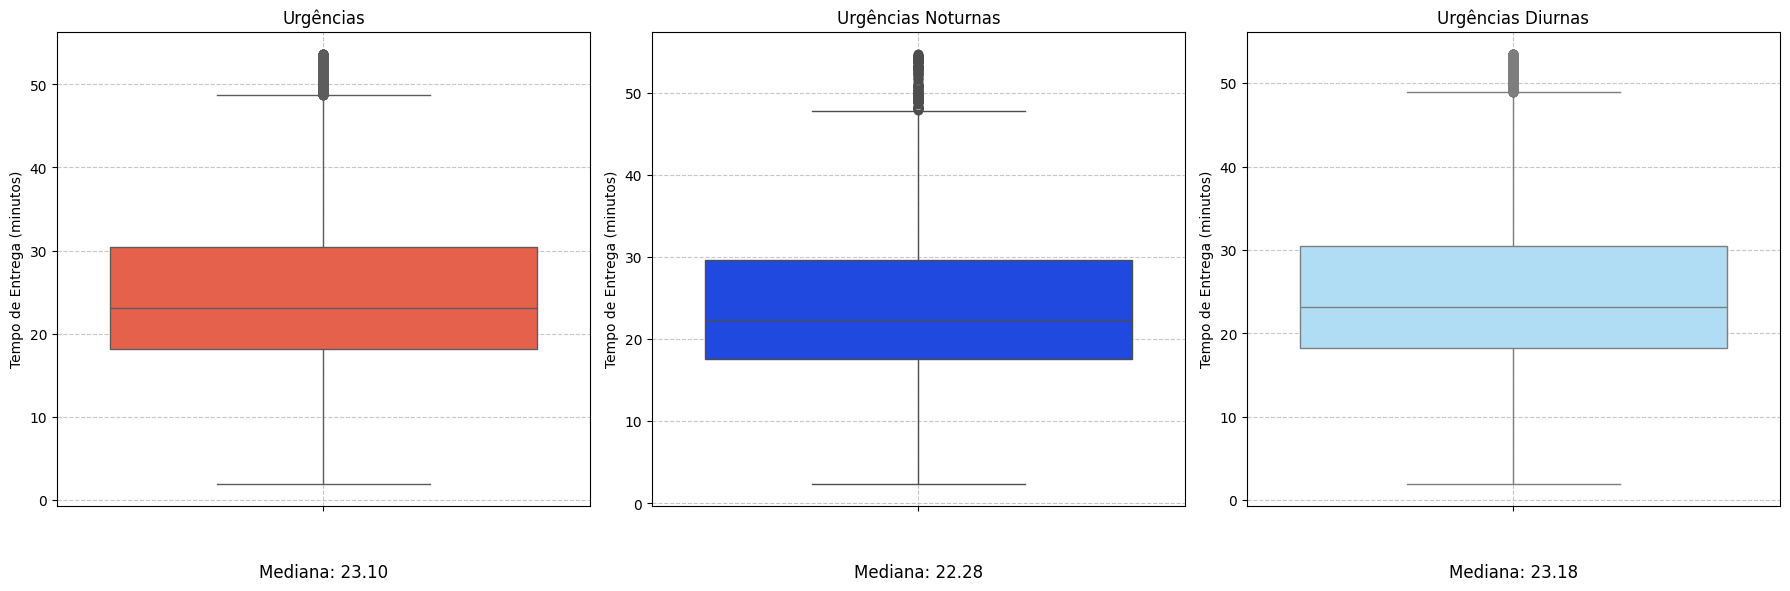

In [ ]:
# @title Boxplots - without Outliers

def criar_boxplot_sem_outliers(df, ax, color, title):
    """Cria um box plot sem outliers para o DataFrame fornecido."""
    Q1 = df['Tempo de entrega (minutos)'].quantile(0.25)
    Q3 = df['Tempo de entrega (minutos)'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_sem_outliers = df[
        (df['Tempo de entrega (minutos)'] >= limite_inferior) &
        (df['Tempo de entrega (minutos)'] <= limite_superior)
    ]
    sns.boxplot(y=df_sem_outliers['Tempo de entrega (minutos)'], color=color, ax=ax)
    ax.set_ylabel('Tempo de Entrega (minutos)')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.7)
    return df_sem_outliers  # Retorna o DataFrame sem outliers para calcular a mediana

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Criando os box plots e obtendo os DataFrames sem outliers
df1_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia, axes[0], '#ff4e33', 'Urgências')
df2_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia_noturno, axes[1], '#0037ff', 'Urgências Noturnas')
df3_sem_outliers = criar_boxplot_sem_outliers(Tempos_Limpo_Urgencia_Diurno, axes[2], '#a6e1ff', 'Urgências Diurnas')

# Calculando as medianas
medianas = [
    df1_sem_outliers['Tempo de entrega (minutos)'].median(),
    df2_sem_outliers['Tempo de entrega (minutos)'].median(),
    df3_sem_outliers['Tempo de entrega (minutos)'].median()
]

# Exibindo as medianas abaixo dos gráficos
x_pos = np.arange(3) + 0.5
for i, mediana in enumerate(medianas):
    axes[i].text(0.5, -0.15, f'Mediana: {mediana:.2f}', transform=axes[i].transAxes, ha='center', fontsize=12)

plt.tight_layout()
plt.show()

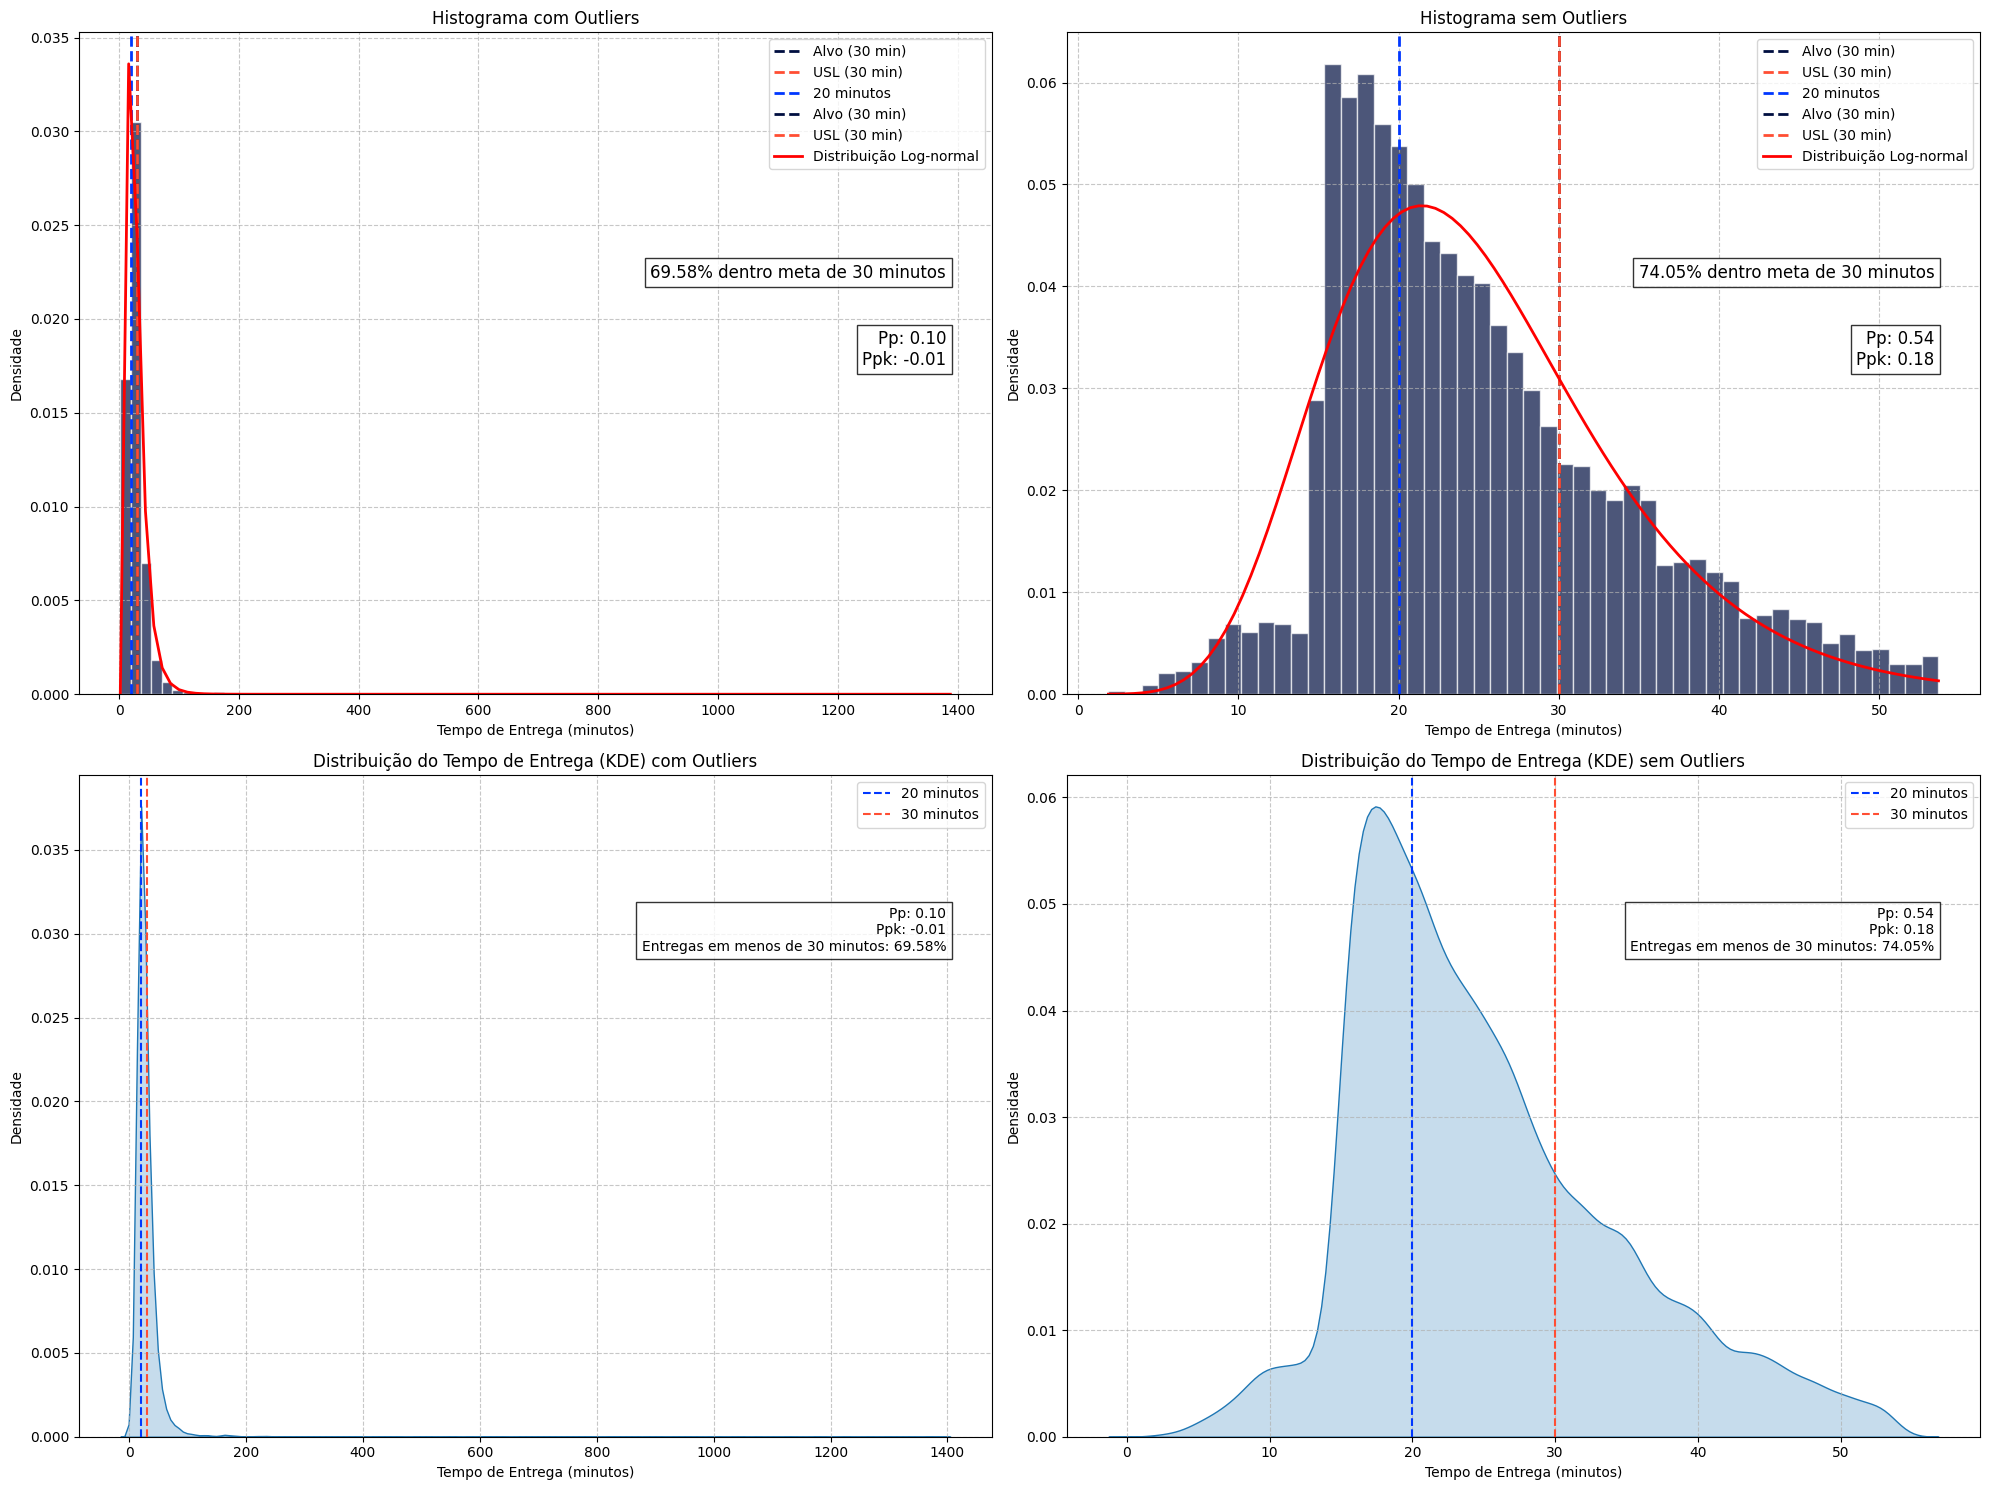

In [ ]:
# @title Histogramas and KDEs

# Criar e customizar histograma
def criar_histograma(data, ax, title, bins=30, target=30, USL=30, LSL=0):
    # Calculo da porcentagem abaixo de 30 minutos
    porcentagem_abaixo_da_meta = (data[data < target].count() / len(data)) * 100

    # Adicionar linha para o alvo (30 minutos) e a meta (20 minutos)
    ax.axvline(target, color='#000e40', linestyle='--', linewidth=2, label=f'Alvo ({target} min)')
    ax.axvline(USL, color='#ff4e33', linestyle='--', linewidth=2, label=f'USL ({USL} min)')
    ax.axvline(20, color='#0037ff', linestyle='--', linewidth=2, label='20 minutos')  # linha da meta

    # Calculo do desvio padrão
    desvio_padrao = np.std(data, ddof=1)

    # Calculo do Pp and Ppk
    Pp = (USL - LSL) / (6 * desvio_padrao)
    Ppk = min((USL - data.mean()) / (3 * desvio_padrao), (data.mean() - LSL) / (3 * desvio_padrao))

    # Colocar a distribuição lognormal
    shape, loc, scale = stats.lognorm.fit(data)
    x = np.linspace(min(data), max(data), 100)
    pdf_lognormal = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

    # Criar histograma
    ax.hist(data, bins=bins, density=True, alpha=0.7, color='#000e40', edgecolor='#ffffff')
    ax.axvline(target, color='#000e40', linestyle='--', linewidth=2, label=f'Alvo ({target} min)')
    ax.axvline(USL, color='#ff4e33', linestyle='--', linewidth=2, label=f'USL ({USL} min)')
    ax.plot(x, pdf_lognormal, 'r-', lw=2, label='Distribuição Log-normal')

    # Adicionar os textos (PP, PPK, % dentro da meta...)
    ax.text(0.95, 0.55, f'Pp: {Pp:.2f}\nPpk: {Ppk:.2f}', transform=ax.transAxes, ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.95, 0.65, f'{porcentagem_abaixo_da_meta:.2f}% dentro meta de 30 minutos', transform=ax.transAxes, ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.set_xlabel('Tempo de Entrega (minutos)')
    ax.set_ylabel('Densidade')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Criar figura com 4 subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(20,15))

# Dados para cada histograma
data_com_outliers = Tempos_Limpo_Urgencia['Tempo de entrega (minutos)']
data_sem_outliers = df1_sem_outliers['Tempo de entrega (minutos)']

# Criar Histograma com Outliers
criar_histograma(data_com_outliers, axes[0, 0], 'Histograma com Outliers', bins=80)


# Criar Histograma sem Outliers
criar_histograma(data_sem_outliers, axes[0, 1], 'Histograma sem Outliers', bins=50)


# KDE com Outliers
sns.kdeplot(data=Tempos_Limpo_Urgencia, x='Tempo de entrega (minutos)', fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribuição do Tempo de Entrega (KDE) com Outliers')
axes[1, 0].set_xlabel('Tempo de Entrega (minutos)')
axes[1, 0].set_ylabel('Densidade')
axes[1, 0].grid(True, linestyle='--', alpha=0.7)
axes[1, 0].axvline(20, color='#0037ff', linestyle='--', label='20 minutos')
axes[1, 0].axvline(30, color='#ff4e33', linestyle='--', label='30 minutos')

# Calcular pp e ppk
USL = 30  # Alvo (Limite superior)
LSL = 0   # Limite inferior
target = 20  # Meta
data = Tempos_Limpo_Urgencia['Tempo de entrega (minutos)']
desvio_padrao = np.std(data, ddof=1)
Pp = (USL - LSL) / (6 * desvio_padrao)
Ppk = min((USL - data.mean()) / (3 * desvio_padrao), (data.mean() - LSL) / (3 * desvio_padrao))
porcentagem_abaixo_30 = (data[data < 30].count() / len(data)) * 100
axes[1, 0].text(0.95, 0.80, f'Pp: {Pp:.2f}\nPpk: {Ppk:.2f}\nEntregas em menos de 30 minutos: {porcentagem_abaixo_30:.2f}%',
             transform=axes[1, 0].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes[1, 0].legend()


# KDE sem Outliers
sns.kdeplot(data=df1_sem_outliers, x='Tempo de entrega (minutos)', fill=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribuição do Tempo de Entrega (KDE) sem Outliers')
axes[1, 1].set_xlabel('Tempo de Entrega (minutos)')
axes[1, 1].set_ylabel('Densidade')
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].axvline(20, color='#0037ff', linestyle='--', label='20 minutos')
axes[1, 1].axvline(30, color='#ff4e33', linestyle='--', label='30 minutos')
# Calcular Pp e Ppk sem outliers
data = df1_sem_outliers['Tempo de entrega (minutos)']
desvio_padrao = np.std(data, ddof=1)
Pp = (USL - LSL) / (6 * desvio_padrao)
Ppk = min((USL - data.mean()) / (3 * desvio_padrao), (data.mean() - LSL) / (3 * desvio_padrao))
porcentagem_abaixo_30 = (data[data < 30].count() / len(data)) * 100
axes[1, 1].text(0.95, 0.80, f'Pp: {Pp:.2f}\nPpk: {Ppk:.2f}\nEntregas em menos de 30 minutos: {porcentagem_abaixo_30:.2f}%',
             transform=axes[1, 1].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes[1, 1].legend()

# Ajustar layout e mostrar
plt.tight_layout()
plt.show()

# 3.1.2. - Normality Test and First Analyses - Test Data

The median delivery time for urgent medications, considering both day and night periods, is 22 minutes. Separately, the median delivery time at night is 21 minutes, while the median delivery time during the day is 22 minutes. The percentage of items that exceeded 30 minutes is 30.41%, and the 0.9 percentile (90th percentile) of the delivery time for urgent medications is 44.77 minutes.

Outliers are determined as values above Q3 + 4*IQR (value adapted for the long tail phenomenon), which results in 88.95 minutes. The total number of urgent batches dispensed is 74,477, with a percentage of outliers of 1.78%, representing approximately 1,326.42 batches.

It is possible to see the long tail phenomenon in the histogram and KDE. Furthermore, there is a disproportion between the mean and the median, with the mean approaching the third quartile, with an IQR (Interquartile Range) of 12 minutes. These factors indicate the need for a model that fits a non-Gaussian pattern.

As the mean is approaching the third quartile, I tried to remove the influence of outliers to recalculate and assess whether the pattern would follow normality or lognormality. I will consider the value of the third quartile + 1.5 * IQR in this analysis, resulting in values below 50 minutes (rounded).

Even after removing the outliers, the Anderson-Darling test rejects the hypothesis of a normal or lognormal distribution. The residual plot with outliers does not corroborate the interpretation contrary to the Anderson-Darling test, but without the outliers, it shows an improvement in the pattern, which could contradict the test result.

### Conclusions on Normality
Although the residual plot without outliers (above 50 minutes) demonstrates a possibility of considering the lognormal distribution for the data, I will choose to continue with options that do not assume a normal distribution for the model, thus allowing the inclusion of outliers. I would only have justification for removing outliers above 90 minutes (incorrect prescriptions or those that were not really urgent), which represent less than 2% of the data. Considering values above 50 minutes as delays by the pharmacy team is plausible, as they represent 7% of the data.

In [ ]:
# @title ## Create o DF without outliers ##

# Contar o número total de linhas antes de remover
total_linhas_inicial = Tempos_Limpo_Urgencia.shape[0]

# Contar o número de valores acima de 50
valores_acima_50 = Tempos_Limpo_Urgencia[Tempos_Limpo_Urgencia['Tempo de entrega (minutos)'] > 50].shape[0]

# Remover valores acima de 50
df1_sem_outliers = Tempos_Limpo_Urgencia[Tempos_Limpo_Urgencia['Tempo de entrega (minutos)'] <= 50]

# Contar o número total de linhas após remover
total_linhas_final = df1_sem_outliers.shape[0]

# Calcular a porcentagem de valores removidos
percentual_removido = (valores_acima_50 / total_linhas_inicial) * 100

# Printa a quantidade de valores removidos e a porcentagem
print(f"Quantidade de valores retirados: {valores_acima_50}")
print(f"Porcentagem de valores retirados: {percentual_removido:.2f}%")

Quantidade de valores retirados: 3949
Porcentagem de valores retirados: 7.27%


In [ ]:
#@title ## Separate data with and without outliers ##
data_sem_outliers = df1_sem_outliers['Tempo de entrega (minutos)']
data_com_outliers = Tempos_Limpo_Urgencia['Tempo de entrega (minutos)']

# --- Teste Anderson-Darling Normalidade---

# Sem outliers
result_sem_outliers = stats.anderson(data_sem_outliers, dist='norm')
statistic_sem_outliers = result_sem_outliers.statistic
critical_values_sem_outliers = result_sem_outliers.critical_values
significance_level_sem_outliers = result_sem_outliers.significance_level

# Com outliers
result_com_outliers = stats.anderson(data_com_outliers, dist='norm')
statistic_com_outliers = result_com_outliers.statistic
critical_values_com_outliers = result_com_outliers.critical_values
significance_level_com_outliers = result_com_outliers.significance_level

# --- Teste Anderson-Darling LogNormalidade---

# Sem outliers
result_sem_outliers_lognormal = stats.anderson(np.log(data_sem_outliers), dist='norm')  # Transformação logaritimica
statistic_sem_outliers_lognormal = result_sem_outliers_lognormal.statistic
critical_values_sem_outliers_lognormal = result_sem_outliers_lognormal.critical_values
significance_level_sem_outliers_lognormal = result_sem_outliers_lognormal.significance_level

# Com outliers
result_com_outliers_lognormal = stats.anderson(np.log(data_com_outliers), dist='norm')   # Transformação logaritimica
statistic_com_outliers_lognormal = result_com_outliers_lognormal.statistic
critical_values_com_outliers_lognormal = result_com_outliers_lognormal.critical_values
significance_level_com_outliers_lognormal = result_com_outliers_lognormal.significance_level

# --- Printar os resultados com conclusões ---
print("Anderson-Darling Resultados e conclusões:")
print("----------------------------------------------")

def interpret_anderson_darling(result, data_description):
    """Interprets the Anderson-Darling test results and prints the conclusion."""
    statistic = result.statistic
    critical_values = result.critical_values
    significance_levels = result.significance_level

    print(f"\n{data_description}:")
    print(f"  Estatística: {statistic}")
    print(f"  Valores Críticos: {critical_values}")
    print(f"  Nível de Significância: {significance_levels}")
    print("")

    if statistic > critical_values[2]:  # Using a significance level of 5%
        print("  **Não segue a distribuição Normal (5% de significância).**")
    else:
        print("  **Segue a distribuição Normal (5% de significância).**")

        print("") #Apenas para dar um espaço entre os resultados e a interpretação

# Interpretação para cada caso (nessa epóca eu ainda não tinha dominado direito a interpretação, então criei uma forma de facilitar minha vida)
interpret_anderson_darling(result_sem_outliers, "Sem Outliers (Normal)")
interpret_anderson_darling(result_com_outliers, "Com Outliers (Normal)")
interpret_anderson_darling(result_sem_outliers_lognormal, "Sem Outliers (Log-Normal)")
interpret_anderson_darling(result_com_outliers_lognormal, "Com Outliers (Log-Normal)")

Anderson-Darling Resultados e conclusões:
----------------------------------------------

Sem Outliers (Normal):
  Estatística: 777.7310060816453
  Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
  Nível de Significância: [15.  10.   5.   2.5  1. ]

  **Não segue a distribuição Normal (5% de significância).**

Com Outliers (Normal):
  Estatística: 11353.018618464572
  Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
  Nível de Significância: [15.  10.   5.   2.5  1. ]

  **Não segue a distribuição Normal (5% de significância).**

Sem Outliers (Log-Normal):
  Estatística: 155.7074150998451
  Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
  Nível de Significância: [15.  10.   5.   2.5  1. ]

  **Não segue a distribuição Normal (5% de significância).**

Com Outliers (Log-Normal):
  Estatística: 879.5010851728948
  Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
  Nível de Significância: [15.  10.   5.   2.5  1. ]

  **Não segue a distribuição Normal (5% de significância).**


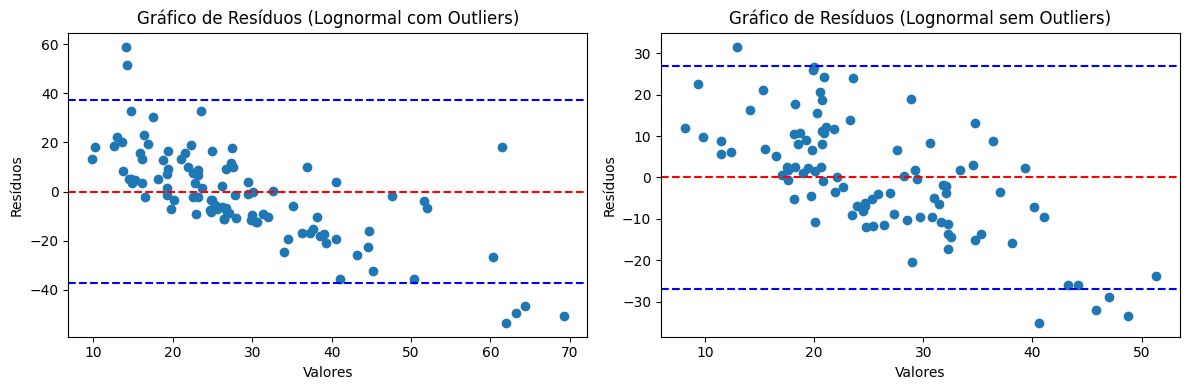

In [ ]:
# @title #Residual Plot With and Without Outliers
# Dados para o teste
data = Tempos_Limpo_Urgencia['Tempo de entrega (minutos)']

# Amostragem para lognormal
tamanho_amostra_lognormal = 100
amostra_lognormal = data.sample(tamanho_amostra_lognormal)

# Ajustar a distribuição lognormal
shape, loc, scale = stats.lognorm.fit(amostra_lognormal)
valores_preditos_lognormal = stats.lognorm.rvs(shape, loc=loc, scale=scale, size=tamanho_amostra_lognormal)
residuos_lognormal = amostra_lognormal - valores_preditos_lognormal

# Remover outliers da amostra lognormal usando IQR
Q1 = amostra_lognormal.quantile(0.25)
Q3 = amostra_lognormal.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
amostra_lognormal_sem_outliers = amostra_lognormal[(amostra_lognormal >= limite_inferior) & (amostra_lognormal <= limite_superior)]

# Ajustar a distribuição lognormal à amostra sem outliers
shape_sem_outliers, loc_sem_outliers, scale_sem_outliers = stats.lognorm.fit(amostra_lognormal_sem_outliers)
valores_preditos_lognormal_sem_outliers = stats.lognorm.rvs(shape_sem_outliers, loc=loc_sem_outliers, scale=scale_sem_outliers, size=len(amostra_lognormal_sem_outliers))
residuos_lognormal_sem_outliers = amostra_lognormal_sem_outliers - valores_preditos_lognormal_sem_outliers

# Calcular os limites do intervalo de confiança (95%) para a amostra com outliers
desvio_padrao_residuos_lognormal = np.std(residuos_lognormal)
limite_inferior_lognormal = -1.96 * desvio_padrao_residuos_lognormal
limite_superior_lognormal = 1.96 * desvio_padrao_residuos_lognormal

# Calcular os limites do intervalo de confiança (95%) para a amostra sem outliers
desvio_padrao_residuos_lognormal_sem_outliers = np.std(residuos_lognormal_sem_outliers)
limite_inferior_lognormal_sem_outliers = -1.96 * desvio_padrao_residuos_lognormal_sem_outliers
limite_superior_lognormal_sem_outliers = 1.96 * desvio_padrao_residuos_lognormal_sem_outliers

# Criar a figura e os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. Gráfico de resíduos (lognormal com outliers)
axes[0].scatter(valores_preditos_lognormal, residuos_lognormal)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].axhline(y=limite_inferior_lognormal, color='b', linestyle='--', label='Limite Inferior (95% CI)')
axes[0].axhline(y=limite_superior_lognormal, color='b', linestyle='--', label='Limite Superior (95% CI)')
axes[0].set_title('Gráfico de Resíduos (Lognormal com Outliers)')
axes[0].set_xlabel('Valores')
axes[0].set_ylabel('Resíduos')

# 2. Gráfico de resíduos (lognormal sem outliers)
axes[1].scatter(valores_preditos_lognormal_sem_outliers, residuos_lognormal_sem_outliers)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].axhline(y=limite_inferior_lognormal_sem_outliers, color='b', linestyle='--', label='Limite Inferior (95% CI)')
axes[1].axhline(y=limite_superior_lognormal_sem_outliers, color='b', linestyle='--', label='Limite Superior (95% CI)')
axes[1].set_title('Gráfico de Resíduos (Lognormal sem Outliers)')
axes[1].set_xlabel('Valores')
axes[1].set_ylabel('Resíduos')

# Ajustar o layout e exibir a figura
plt.tight_layout()

# 3.2.1. Evaluate the Behavior of Variables - Validation Data

In [ ]:
# @title Simple Statistics
# Calcula o número total de entregas de urgência
total_entregas = len(Tempos_Limpo_validacao_Urgencia)

# Calcula o número de entregas que passaram de 30 minutos
entregas_acima_30_minutos = len(Tempos_Limpo_validacao_Urgencia[Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)'] > 30])

# Calcula a porcentagem de entregas que passaram de 30 minutos
porcentagem_acima_30_minutos = (entregas_acima_30_minutos / total_entregas) * 100

# Calcula o percentil 0.9
percentil_90 = Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)'].quantile(0.9)

# Calcula a quantidade de Lotes Urgentes
distinct_count = Tempos_Limpo_validacao['Nr sequencia'].nunique()

# Calcular Qual é o valor que representa o terceiro quartil + 4*IQR
Q1 = Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)'].quantile(0.25)
Q3 = Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 4 * IQR

# Calcular quantos % estão acima do valor Q3 + 4*IQR
percentage_above_threshold = (Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)'] > outlier_threshold).mean() * 100

# Calcular quantos lotes estão acima do valor Q3 + 4*IQR
percentage_above_threshold_lotes = percentage_above_threshold*distinct_count/100

# Armazenar as saídas em variáveis
mediana_com_outliers_output = f"Mediana do Tempo de entrega de urgências - Diurno e Noturno: <b>  {hours:02}:{minutes:02}:{seconds:02} </b>"
mediana_tempo_entrega_Urgencias_noturno_output = f"Mediana do Tempo de entrega (Noturno): <b> {hours_noturno:02}:{minutes_noturno:02}:{seconds_noturno:02} </b> "
mediana_tempo_entrega_Urgencias_diurno_output = f"Mediana do Tempo de entrega (Diurno): <b>  {hours_diurno:02}:{minutes_diurno:02}:{seconds_business_diurno:02} </b> "
porcentagem_output = f"A porcentagem de itens que passaram de 30 minutos é: <b> {porcentagem_acima_30_minutos:.2f}% </b> "
percentil_output = f"O percentil 0.9 (90º percentil) do tempo de entrega das urgências é: <b> {percentil_90:.2f} minutos </b> "
distinct_count_output = f'A quantidade total de Lotes Urgentes dispensados é: <b> {distinct_count} lotes </b> '
outlier_threshold_output = f'Outliers = Q3 + 4*IQR é: <b> {outlier_threshold:.2f} minutos </b> '
percentage_above_threshold_output = f'A porcentagem de outliers é: <b> {percentage_above_threshold:.2f}% </b>, que representa <b> {percentage_above_threshold_lotes:.2f} Lotes </b> '

# Criar um HTML com todos os textos em um tamanho maior (fiz isso porque os números saem muito pequenos no meu monitor - depois descobri que podia dar zoom, mas pelo menos serviu para aprender a criar esse tipo de saída)
html_output = f"""
<font size='4'>
  <p>{mediana_com_outliers_output}</p>


  <p>{mediana_tempo_entrega_Urgencias_noturno_output}</p>


  <p>{mediana_tempo_entrega_Urgencias_diurno_output}</p>


  <p>{porcentagem_output}</p>


  <p>{percentil_output}</p>


    <p>{outlier_threshold_output}</p>

    <p>{distinct_count_output}</p>

  <p>{percentage_above_threshold_output}</p>
</font>
"""

# Exibir a saída com o HTML
display(HTML(html_output))

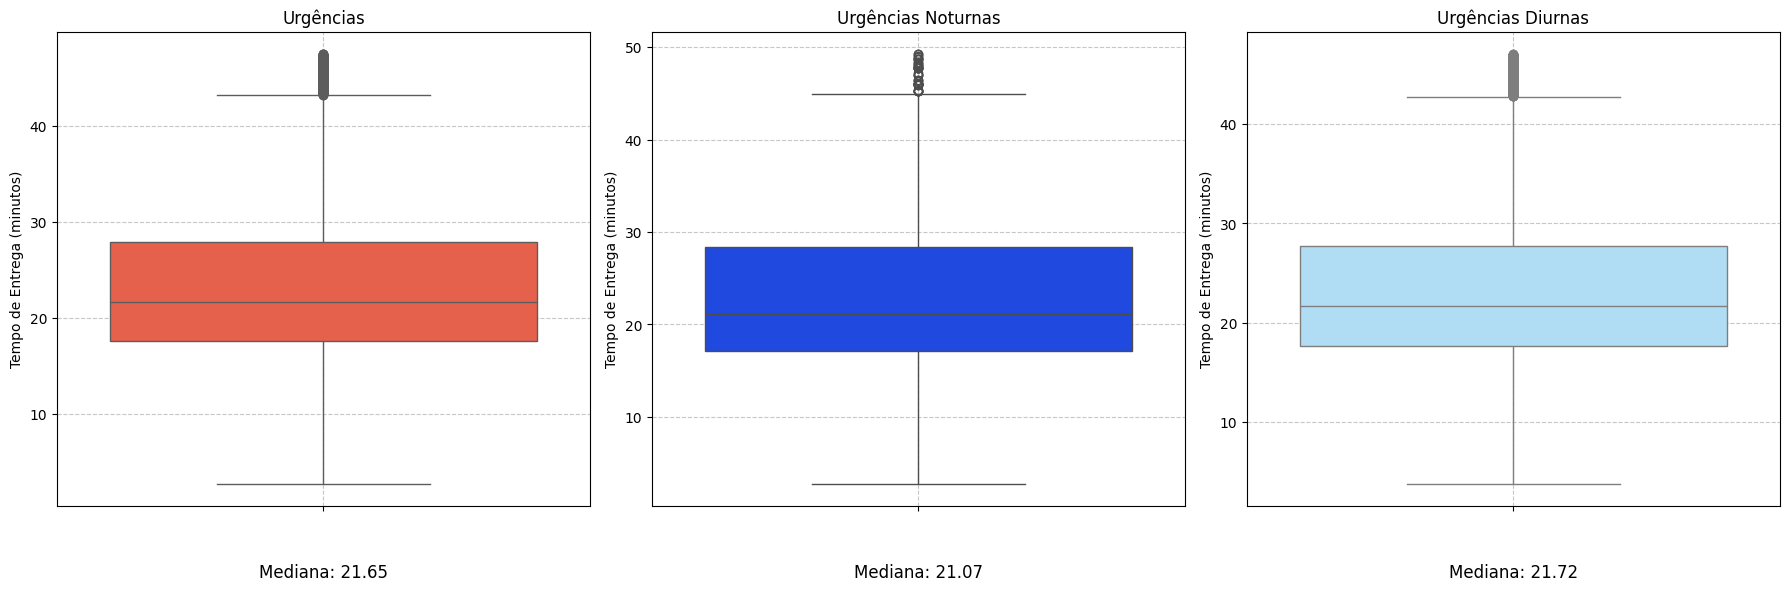

In [ ]:
# @title Boxplots - without Outliers

def criar_boxplot__validacao(df, ax, color, title):
    """Cria um box plot sem outliers para o DataFrame fornecido."""
    Q1 = df['Tempo de entrega (minutos)'].quantile(0.25)
    Q3 = df['Tempo de entrega (minutos)'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df__validacao = df[
        (df['Tempo de entrega (minutos)'] >= limite_inferior) &
        (df['Tempo de entrega (minutos)'] <= limite_superior)
    ]
    sns.boxplot(y=df__validacao['Tempo de entrega (minutos)'], color=color, ax=ax)
    ax.set_ylabel('Tempo de Entrega (minutos)')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.7)
    return df__validacao  # Retorna o DataFrame sem outliers para calcular a mediana

# Criando a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Criando os box plots e obtendo os DataFrames sem outliers
df1__validacao = criar_boxplot__validacao(Tempos_Limpo_validacao_Urgencia, axes[0], '#ff4e33', 'Urgências')
df2__validacao = criar_boxplot__validacao(Tempos_Limpo_validacao_Urgencia_noturno, axes[1], '#0037ff', 'Urgências Noturnas')
df3__validacao = criar_boxplot__validacao(Tempos_Limpo_validacao_Urgencia_Diurno, axes[2], '#a6e1ff', 'Urgências Diurnas')

# Calculando as medianas
medianas = [
    df1__validacao['Tempo de entrega (minutos)'].median(),
    df2__validacao['Tempo de entrega (minutos)'].median(),
    df3__validacao['Tempo de entrega (minutos)'].median()
]

# Exibindo as medianas abaixo dos gráficos
x_pos = np.arange(3) + 0.5
for i, mediana in enumerate(medianas):
    axes[i].text(0.5, -0.15, f'Mediana: {mediana:.2f}', transform=axes[i].transAxes, ha='center', fontsize=12)

plt.tight_layout()
plt.show()

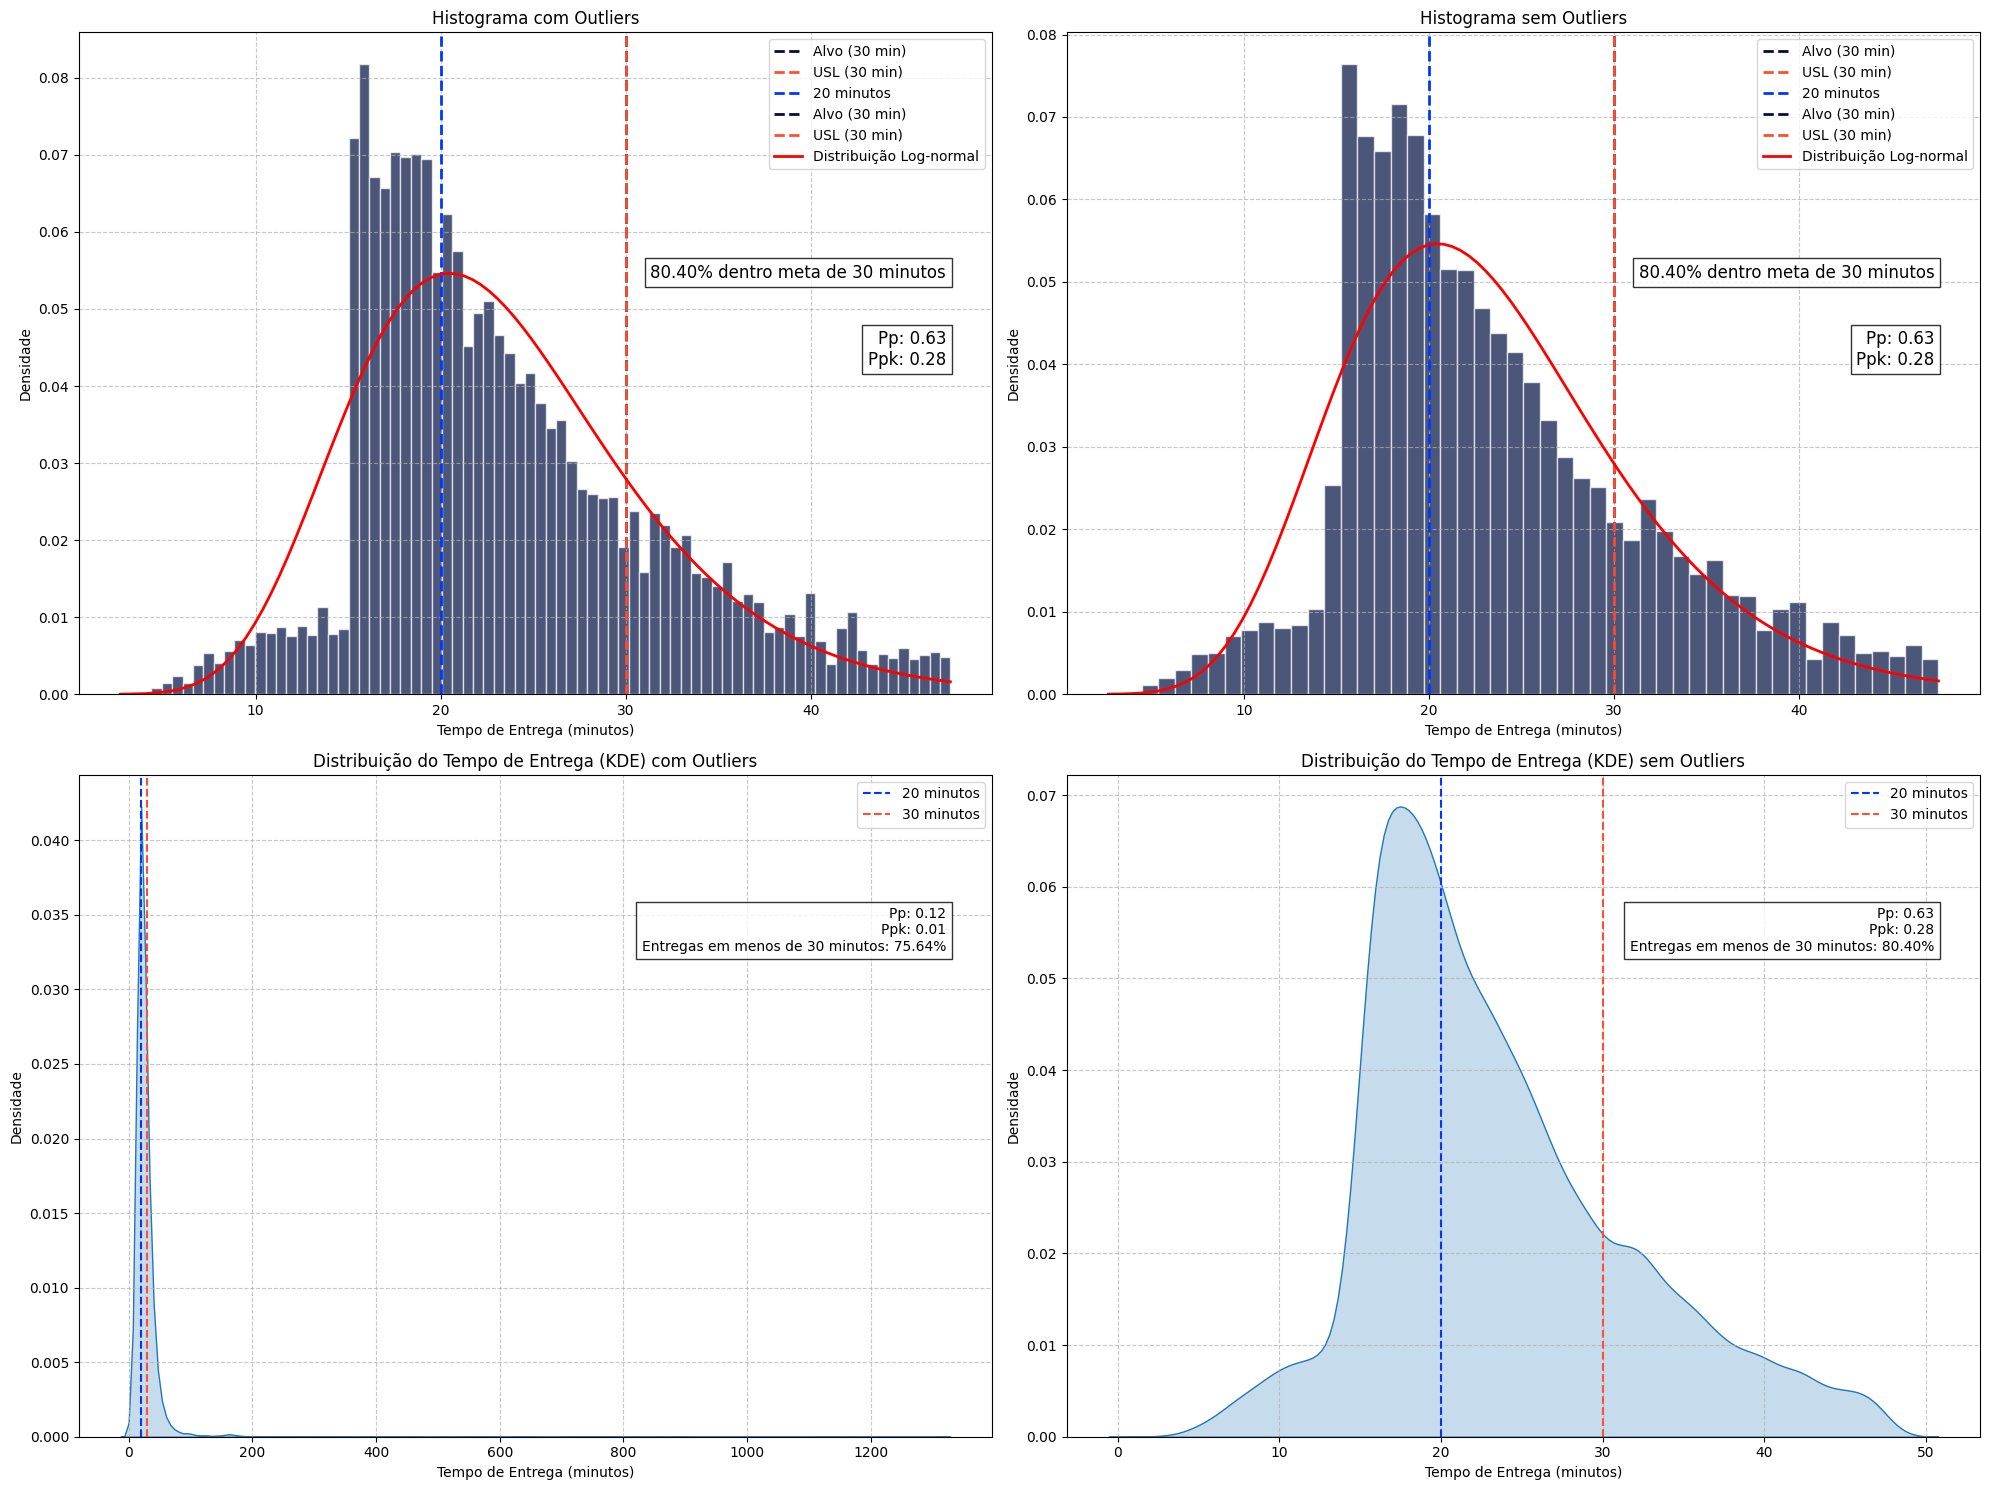

In [ ]:
# @title Histogramas and KDEs

# Criar e customizar histograma
def criar_histograma(data, ax, title, bins=30, target=30, USL=30, LSL=0):
    # Calculo da porcentagem abaixo de 30 minutos
    porcentagem_abaixo_da_meta = (data[data < target].count() / len(data)) * 100

    # Adicionar linha para o alvo (30 minutos) e a meta (20 minutos)
    ax.axvline(target, color='#000e40', linestyle='--', linewidth=2, label=f'Alvo ({target} min)')
    ax.axvline(USL, color='#ff4e33', linestyle='--', linewidth=2, label=f'USL ({USL} min)')
    ax.axvline(20, color='#0037ff', linestyle='--', linewidth=2, label='20 minutos')  # linha da meta

    # Calculo do desvio padrão
    desvio_padrao = np.std(data, ddof=1)

    # Calculo do Pp and Ppk
    Pp = (USL - LSL) / (6 * desvio_padrao)
    Ppk = min((USL - data.mean()) / (3 * desvio_padrao), (data.mean() - LSL) / (3 * desvio_padrao))

    # Colocar a distribuição lognormal
    shape, loc, scale = stats.lognorm.fit(data)
    x = np.linspace(min(data), max(data), 100)
    pdf_lognormal = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

    # Criar histograma
    ax.hist(data, bins=bins, density=True, alpha=0.7, color='#000e40', edgecolor='#ffffff')
    ax.axvline(target, color='#000e40', linestyle='--', linewidth=2, label=f'Alvo ({target} min)')
    ax.axvline(USL, color='#ff4e33', linestyle='--', linewidth=2, label=f'USL ({USL} min)')
    ax.plot(x, pdf_lognormal, 'r-', lw=2, label='Distribuição Log-normal')

    # Adicionar os textos (PP, PPK, % dentro da meta...)
    ax.text(0.95, 0.55, f'Pp: {Pp:.2f}\nPpk: {Ppk:.2f}', transform=ax.transAxes, ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.95, 0.65, f'{porcentagem_abaixo_da_meta:.2f}% dentro meta de 30 minutos', transform=ax.transAxes, ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.set_xlabel('Tempo de Entrega (minutos)')
    ax.set_ylabel('Densidade')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Criar figura com 4 subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(20,15))

# Dados para cada histograma
data_com_outliers_validacao = Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)']
data_com_outliers_validacao = df1__validacao['Tempo de entrega (minutos)']

# Criar Histograma com Outliers
criar_histograma(data_com_outliers_validacao, axes[0, 0], 'Histograma com Outliers', bins=80)


# Criar Histograma sem Outliers
criar_histograma(data_com_outliers_validacao, axes[0, 1], 'Histograma sem Outliers', bins=50)


# KDE com Outliers
sns.kdeplot(data=Tempos_Limpo_validacao_Urgencia, x='Tempo de entrega (minutos)', fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribuição do Tempo de Entrega (KDE) com Outliers')
axes[1, 0].set_xlabel('Tempo de Entrega (minutos)')
axes[1, 0].set_ylabel('Densidade')
axes[1, 0].grid(True, linestyle='--', alpha=0.7)
axes[1, 0].axvline(20, color='#0037ff', linestyle='--', label='20 minutos')
axes[1, 0].axvline(30, color='#ff4e33', linestyle='--', label='30 minutos')


# Calcular pp e ppk
USL = 30  # Alvo (Limite superior)
LSL = 0   # Limite inferior
target = 20  # Meta
data = Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)']
desvio_padrao = np.std(data, ddof=1)
Pp = (USL - LSL) / (6 * desvio_padrao)
Ppk = min((USL - data.mean()) / (3 * desvio_padrao), (data.mean() - LSL) / (3 * desvio_padrao))
porcentagem_abaixo_30 = (data[data < 30].count() / len(data)) * 100
axes[1, 0].text(0.95, 0.80, f'Pp: {Pp:.2f}\nPpk: {Ppk:.2f}\nEntregas em menos de 30 minutos: {porcentagem_abaixo_30:.2f}%',
             transform=axes[1, 0].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes[1, 0].legend()


# KDE sem Outliers
sns.kdeplot(data=df1__validacao, x='Tempo de entrega (minutos)', fill=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribuição do Tempo de Entrega (KDE) sem Outliers')
axes[1, 1].set_xlabel('Tempo de Entrega (minutos)')
axes[1, 1].set_ylabel('Densidade')
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].axvline(20, color='#0037ff', linestyle='--', label='20 minutos')
axes[1, 1].axvline(30, color='#ff4e33', linestyle='--', label='30 minutos')
# Calcular Pp e Ppk sem outliers
data = df1__validacao['Tempo de entrega (minutos)']
desvio_padrao = np.std(data, ddof=1)
Pp = (USL - LSL) / (6 * desvio_padrao)
Ppk = min((USL - data.mean()) / (3 * desvio_padrao), (data.mean() - LSL) / (3 * desvio_padrao))
porcentagem_abaixo_30 = (data[data < 30].count() / len(data)) * 100
axes[1, 1].text(0.95, 0.80, f'Pp: {Pp:.2f}\nPpk: {Ppk:.2f}\nEntregas em menos de 30 minutos: {porcentagem_abaixo_30:.2f}%',
             transform=axes[1, 1].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
axes[1, 1].legend()

# Ajustar layout e mostrar
plt.tight_layout()
plt.show()

# 3.2.2. - Normality Test - Validation Data

- Behavior similar to test data.

In [ ]:
# @title ## Criar o DF without outliers ##

# Contar o número total de linhas antes de remover
total_linhas_inicial = Tempos_Limpo_validacao_Urgencia.shape[0]

# Contar o número de valores acima de 50
valores_acima_50 = Tempos_Limpo_validacao_Urgencia[Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)'] > 50].shape[0]

# Remover valores acima de 50
df1__validacao = Tempos_Limpo_validacao_Urgencia[Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)'] <= 50]

# Contar o número total de linhas após remover
total_linhas_final = df1__validacao.shape[0]

# Calcular a porcentagem de valores removidos
percentual_removido = (valores_acima_50 / total_linhas_inicial) * 100

# Printa a quantidade de valores removidos e a porcentagem
print(f"Quantidade de valores retirados: {valores_acima_50}")
print(f"Porcentagem de valores retirados: {percentual_removido:.2f}%")

Quantidade de valores retirados: 1222
Porcentagem de valores retirados: 5.32%


In [ ]:
#@title ## Separate data with and without outliers ##
data_sem_outliers = df1__validacao['Tempo de entrega (minutos)']
data_com_outliers = Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)']

# --- Teste Anderson-Darling Normalidade---

# Sem outliers
result_sem_outliers = stats.anderson(data_sem_outliers, dist='norm')
statistic_sem_outliers = result_sem_outliers.statistic
critical_values_sem_outliers = result_sem_outliers.critical_values
significance_level_sem_outliers = result_sem_outliers.significance_level

# Com outliers
result_com_outliers = stats.anderson(data_com_outliers, dist='norm')
statistic_com_outliers = result_com_outliers.statistic
critical_values_com_outliers = result_com_outliers.critical_values
significance_level_com_outliers = result_com_outliers.significance_level

# --- Teste Anderson-Darling LogNormalidade---

# Sem outliers
result_sem_outliers_lognormal = stats.anderson(np.log(data_sem_outliers), dist='norm')  # Transformação logaritimica
statistic_sem_outliers_lognormal = result_sem_outliers_lognormal.statistic
critical_values_sem_outliers_lognormal = result_sem_outliers_lognormal.critical_values
significance_level_sem_outliers_lognormal = result_sem_outliers_lognormal.significance_level

# Com outliers
result_com_outliers_lognormal = stats.anderson(np.log(data_com_outliers), dist='norm')   # Transformação logaritimica
statistic_com_outliers_lognormal = result_com_outliers_lognormal.statistic
critical_values_com_outliers_lognormal = result_com_outliers_lognormal.critical_values
significance_level_com_outliers_lognormal = result_com_outliers_lognormal.significance_level

# --- Printar os resultados com conclusões ---
print("Anderson-Darling Resultados e conclusões:")
print("----------------------------------------------")

def interpret_anderson_darling(result, data_description):
    """Interprets the Anderson-Darling test results and prints the conclusion."""
    statistic = result.statistic
    critical_values = result.critical_values
    significance_levels = result.significance_level

    print(f"\n{data_description}:")
    print(f"  Estatística: {statistic}")
    print(f"  Valores Críticos: {critical_values}")
    print(f"  Nível de Significância: {significance_levels}")
    print("")

    if statistic > critical_values[2]:  # Using a significance level of 5%
        print("  **Não segue a distribuição Normal (5% de significância).**")
    else:
        print("  **Segue a distribuição Normal (5% de significância).**")

        print("") #Apenas para dar um espaço entre os resultados e a interpretação

# Interpretação para cada caso (nessa epóca eu ainda não tinha dominado direito a interpretação, então criei uma forma de facilitar minha vida)
interpret_anderson_darling(result_sem_outliers, "Sem Outliers (Normal)")
interpret_anderson_darling(result_com_outliers, "Com Outliers (Normal)")
interpret_anderson_darling(result_sem_outliers_lognormal, "Sem Outliers (Log-Normal)")
interpret_anderson_darling(result_com_outliers_lognormal, "Com Outliers (Log-Normal)")

Anderson-Darling Resultados e conclusões:
----------------------------------------------

Sem Outliers (Normal):
  Estatística: 411.61650730108886
  Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
  Nível de Significância: [15.  10.   5.   2.5  1. ]

  **Não segue a distribuição Normal (5% de significância).**

Com Outliers (Normal):
  Estatística: 4579.333029293863
  Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
  Nível de Significância: [15.  10.   5.   2.5  1. ]

  **Não segue a distribuição Normal (5% de significância).**

Sem Outliers (Log-Normal):
  Estatística: 88.64745908313489
  Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
  Nível de Significância: [15.  10.   5.   2.5  1. ]

  **Não segue a distribuição Normal (5% de significância).**

Com Outliers (Log-Normal):
  Estatística: 436.683799195147
  Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
  Nível de Significância: [15.  10.   5.   2.5  1. ]

  **Não segue a distribuição Normal (5% de significância).**


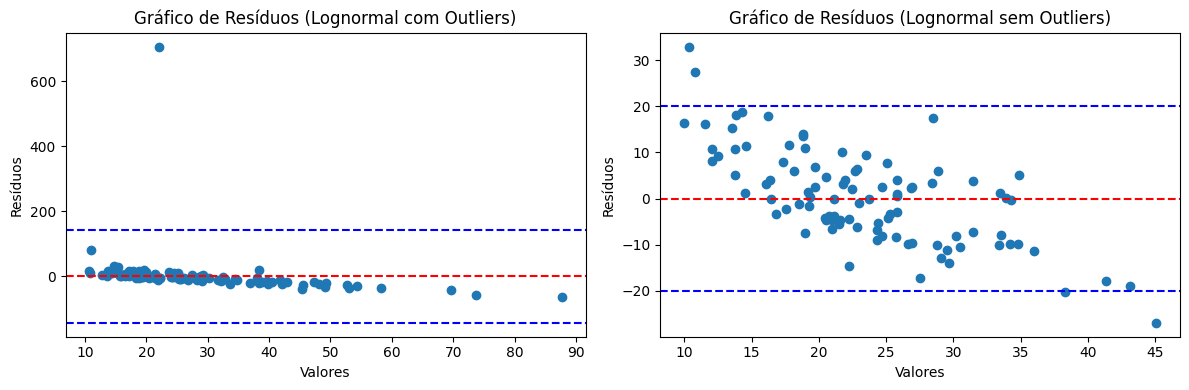

In [ ]:
# @title # Residual Plot With and Without Outliers
# Dados para o teste
data = Tempos_Limpo_validacao_Urgencia['Tempo de entrega (minutos)']

# Amostragem para lognormal
tamanho_amostra_lognormal = 100
amostra_lognormal = data.sample(tamanho_amostra_lognormal)

# Ajustar a distribuição lognormal
shape, loc, scale = stats.lognorm.fit(amostra_lognormal)
valores_preditos_lognormal = stats.lognorm.rvs(shape, loc=loc, scale=scale, size=tamanho_amostra_lognormal)
residuos_lognormal = amostra_lognormal - valores_preditos_lognormal

# Remover outliers da amostra lognormal usando IQR
Q1 = amostra_lognormal.quantile(0.25)
Q3 = amostra_lognormal.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
amostra_lognormal_sem_outliers = amostra_lognormal[(amostra_lognormal >= limite_inferior) & (amostra_lognormal <= limite_superior)]

# Ajustar a distribuição lognormal à amostra sem outliers
shape_sem_outliers, loc_sem_outliers, scale_sem_outliers = stats.lognorm.fit(amostra_lognormal_sem_outliers)
valores_preditos_lognormal_sem_outliers = stats.lognorm.rvs(shape_sem_outliers, loc=loc_sem_outliers, scale=scale_sem_outliers, size=len(amostra_lognormal_sem_outliers))
residuos_lognormal_sem_outliers = amostra_lognormal_sem_outliers - valores_preditos_lognormal_sem_outliers

# Calcular os limites do intervalo de confiança (95%) para a amostra com outliers
desvio_padrao_residuos_lognormal = np.std(residuos_lognormal)
limite_inferior_lognormal = -1.96 * desvio_padrao_residuos_lognormal
limite_superior_lognormal = 1.96 * desvio_padrao_residuos_lognormal

# Calcular os limites do intervalo de confiança (95%) para a amostra sem outliers
desvio_padrao_residuos_lognormal_sem_outliers = np.std(residuos_lognormal_sem_outliers)
limite_inferior_lognormal_sem_outliers = -1.96 * desvio_padrao_residuos_lognormal_sem_outliers
limite_superior_lognormal_sem_outliers = 1.96 * desvio_padrao_residuos_lognormal_sem_outliers

# Criar a figura e os subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. Gráfico de resíduos (lognormal com outliers)
axes[0].scatter(valores_preditos_lognormal, residuos_lognormal)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].axhline(y=limite_inferior_lognormal, color='b', linestyle='--', label='Limite Inferior (95% CI)')
axes[0].axhline(y=limite_superior_lognormal, color='b', linestyle='--', label='Limite Superior (95% CI)')
axes[0].set_title('Gráfico de Resíduos (Lognormal com Outliers)')
axes[0].set_xlabel('Valores')
axes[0].set_ylabel('Resíduos')

# 2. Gráfico de resíduos (lognormal sem outliers)
axes[1].scatter(valores_preditos_lognormal_sem_outliers, residuos_lognormal_sem_outliers)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].axhline(y=limite_inferior_lognormal_sem_outliers, color='b', linestyle='--', label='Limite Inferior (95% CI)')
axes[1].axhline(y=limite_superior_lognormal_sem_outliers, color='b', linestyle='--', label='Limite Superior (95% CI)')
axes[1].set_title('Gráfico de Resíduos (Lognormal sem Outliers)')
axes[1].set_xlabel('Valores')
axes[1].set_ylabel('Resíduos')

# Ajustar o layout e exibir a figura
plt.tight_layout()

# (Extra Step) 1.0. Critical Analysis with Python (Phase 2 of the Timeline)

While the first critical analysis took into account simple statistics to determine process variation and seek root causes for delays, phase 2 used more robust techniques. The analysis started using the third quartile with EWMA, with the objective of identifying anomalies in different days and discussing with the team how to address them.

In addition, the first preliminary comparative analysis tests were carried out, such as the Kruskal-Wallis test, which showed whether there was a significant difference in the median delivery time (applied day by day) for users and sectors.

Additional comparative tests, such as AB and Wilcoxon tests, were also applied to understand if there was a statistical difference in deliveries between different users and sectors (one by one).

This model was quite laborious, as it was necessary to evaluate each user and each sector individually. However, it served as the basis for the idea of using a machine learning model to assess the importance of variables and deepen the critical analysis.

NOTE: I left this section only to demonstrate the data from one of the first analyses.

# (Extra Step) 1.1. Temporal Analyses by Day - 75th Percentile + EWMA

#### Comments -
- 1 - I left some guidelines that I put in to help interpret the results while I did not master every statistical detail needed.
- 2 - I left the code used for this daily analysis and an example with the validation data. For both EWMA and comparative tests.
- 3 - This test proved to be ineffective in developing insights, and the 1-to-1 comparison was very time-consuming, for these reasons it was replaced by the final solution presented in this project.

####.

EWMA, or Exponentially Weighted Moving Average, is a statistical technique used to monitor and analyze time series data, giving more weight to more recent observations.
- Ascending EWMA line: Indicates an upward trend in the delivery time of urgent medications over time. This may signal a problem in the process that needs to be investigated.
- Descending EWMA line: Indicates a downward trend in the delivery time of urgent medications. This suggests that process improvements are being effective.
- Stable EWMA line: Indicates that the delivery time of urgent medications is relatively consistent over time.

<ipython-input-27-86a0cf293a2f>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Tempos_Limpo_validacao_Urgencia1['Dt ger lote'] = pd.to_datetime(Tempos_Limpo_validacao_Urgencia1['Dt ger lote'], errors='coerce')


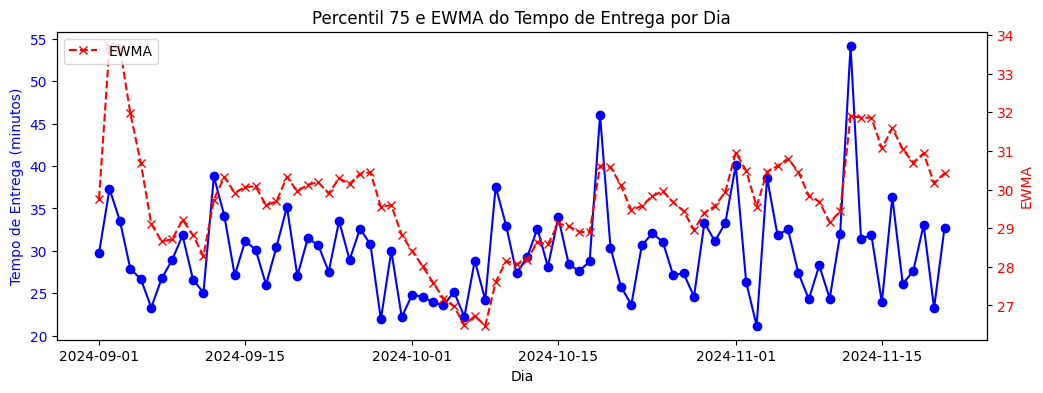

In [ ]:
# @title Day by Day -  EWMA Percetile 0,75
Tempos_Limpo_validacao_Urgencia1['Dt ger lote'] = pd.to_datetime(Tempos_Limpo_validacao_Urgencia1['Dt ger lote'], errors='coerce')

# Agrupar por dia e calcular o percentil 75
tempos_por_dia = Tempos_Limpo_validacao_Urgencia1.groupby(Tempos_Limpo_validacao_Urgencia1['Dt ger lote'].dt.date)['Tempo de entrega (minutos)'].quantile(0.75)

# Calcular a EWMA com um fator de suavização de 0.1
ewma_dia = tempos_por_dia.ewm(alpha=0.1).mean()

# Criar o gráfico
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plotar o percentil 75
ax1.plot(tempos_por_dia.index, tempos_por_dia.values, marker='o', linestyle='-', color='blue', label='Percentil 75')
ax1.set_xlabel('Dia')
ax1.set_ylabel('Tempo de Entrega (minutos)', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Criar um segundo eixo y para a EWMA
ax2 = ax1.twinx()
ax2.plot(ewma_dia.index, ewma_dia.values, marker='x', linestyle='--', color='red', label='EWMA')
ax2.set_ylabel('EWMA', color='red')
ax2.tick_params('y', labelcolor='red')

# Adicionar título e legenda
plt.title('Percentil 75 e EWMA do Tempo de Entrega por Dia')
plt.legend(loc='upper left')
plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos do eixo x para melhor visualização

# Exibir o gráfico
plt.show()
tempos_por_dia = Tempos_Limpo_validacao_Urgencia1.groupby(Tempos_Limpo_validacao_Urgencia1['Dt ger lote'].dt.date)['Tempo de entrega (minutos)'].quantile(0.75)

# (Extra Step) 1.2. Kruskal-Wallis Test

The Kruskal-Wallis test compares the medians of the groups, not the means. This is because the test is non-parametric and makes no assumptions about the distribution of the data.

Seeing this method ensures that the individual comparison between messengers and/or sectors will demonstrate some relevant difference. (Avoids wasting time comparing one by one, if it gives a small p-value it is because we have a significant difference - in this case it is necessary to continue with the analysis)

# (Extra Step) 1.3. AB Test

Considered suitable for comparing users, as there is no required standard for deliveries. In this way, each messenger has their own way of working. These significant differences can demonstrate a superiority in each one's method.

**AB Test**

Performing comparisons - As this is a NON-PARAMETRIC distribution - The Mann-Whitney U test is a test that makes no assumptions about the distribution of the data. This makes it more robust for data that does not follow a normal distribution. It is used to compare method A with method B, that is, there are sufficient differences in the methodology.

### I created buttons to choose who I want to compare and relevant outputs:

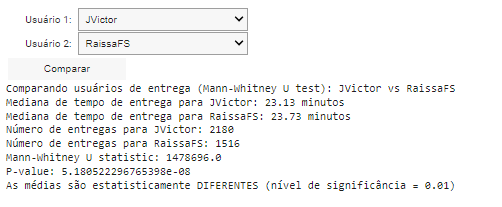

# (Extra Step) 1.4. Wilcoxon Test

The choice of this test to compare delivery between sectors is due to the non-selectivity of users for each sector, that is, all sectors are served by all messengers. In this way, there is no relevant variability in delivery methods.


**Wilcoxon Test**

Performing comparisons - As this is a NON-PARAMETRIC distribution - The Wilcoxon test is a test that makes no assumptions about the distribution of the data. It is used to compare data when they do not differ in methodology.

### I created buttons to choose who I want to compare and relevant outputs:
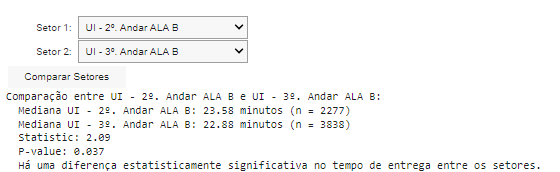

In [ ]:
# @title Kruskal-Wallis Test
grupos_Setores = Tempos_Limpo_validacao_Urgencia1.groupby('Setor paciente')['Tempo de entrega (minutos)'].apply(list)

# Obter os dados de cada grupo
dados_grupos = [grupo for grupo in grupos_Setores]

# Realizar o teste
statistic, pvalue = stats.kruskal(*dados_grupos)

alpha = 0.01  # Nível de significância

# Imprimir os resultados
print('Estatística H:', statistic)
print('Valor-p:', pvalue)

# Conclusões
if pvalue < alpha:
  print(f"Existe uma diferença significativa na mediana de entrega entre os setores")
else:
  print(f"Não Existe uma diferença significativa na mediana de entrega entre os setores")

Estatística H: 475.0439188913646
Valor-p: 9.509322975589807e-89
Existe uma diferença significativa na mediana de entrega entre os setores


In [ ]:
# @title Kruskal-Wallis Teste - Users of delivery
grupos_usuarios = Tempos_Limpo_validacao_Urgencia1.groupby('Usuario entrega')['Tempo de entrega (minutos)'].apply(list)

# Obter os dados de cada grupo
dados_grupos = [grupo for grupo in grupos_usuarios]

# Realizar o teste
statistic, pvalue = stats.kruskal(*dados_grupos)

alpha = 0.01  # Nível de significância

# Imprimir os resultados
print('Estatística H:', statistic)
print('Valor-p:', pvalue)

# Conclusões
if pvalue < alpha:
  print(f"Existe uma diferença significativa na mediana de entrega entre os usuários")
else:
  print(f"Não existe uma diferença significativa na mediana de entrega entre os usuários")

Estatística H: 393.85955356649504
Valor-p: 1.0491178511116027e-58
Existe uma diferença significativa na mediana de entrega entre os usuários


In [ ]:
# @title AB test

# Agrupar por 'Usuario entrega' e calcular a mediana do tempo de entrega para cada grupo
tempos_por_usuario = Tempos_Limpo_validacao_Urgencia1.groupby('Usuario entrega')['Tempo de entrega (minutos)'].median()

# Função para realizar o teste A/B e exibir os resultados
def comparar_usuarios_entrega_ab(usuario1, usuario2):
    # Obter os dados para cada usuário
    dados_usuario1 = Tempos_Limpo_validacao_Urgencia1[Tempos_Limpo_validacao_Urgencia1['Usuario entrega'] == usuario1]['Tempo de entrega (minutos)']
    dados_usuario2 = Tempos_Limpo_validacao_Urgencia1[Tempos_Limpo_validacao_Urgencia1['Usuario entrega'] == usuario2]['Tempo de entrega (minutos)']

    # Calcular a contagem de entregas por usuário
contagem_entregas = Tempos_Limpo_validacao_Urgencia1['Usuario entrega'].value_counts().to_dict() # Define contagem_entregas here

# Função para realizar o teste A/B e exibir os resultados
def comparar_usuarios_entrega_ab(usuario1, usuario2):

    # Obter os dados para cada usuário
    dados_usuario1 = Tempos_Limpo_validacao_Urgencia1[Tempos_Limpo_validacao_Urgencia1['Usuario entrega'] == usuario1]['Tempo de entrega (minutos)']
    dados_usuario2 = Tempos_Limpo_validacao_Urgencia1[Tempos_Limpo_validacao_Urgencia1['Usuario entrega'] == usuario2]['Tempo de entrega (minutos)']

    # Calcular as médias e Contagem
    media_usuario1 = dados_usuario1.median()
    media_usuario2 = dados_usuario2.median()
    contagem_entregas_usuário1=contagem_entregas[usuario1]
    contagem_entregas_usuário2=contagem_entregas[usuario2]

    # Realizar o teste Mann-Whitney U
    statistic, p_value = stats.mannwhitneyu(dados_usuario1, dados_usuario2)

        # Verificar se as médias são estatisticamente diferentes
    alpha = 0.01  # Nível de significância
    if p_value < alpha:
        diferenca_significativa = "DIFERENTES"
    else:
        diferenca_significativa = "IGUAIS"

# Exibir os resultados
    print(f'Comparando usuários de entrega (Mann-Whitney U test): {usuario1} vs {usuario2}')
    print(f'Mediana de tempo de entrega para {usuario1}: {media_usuario1:.2f} minutos')
    print(f'Mediana de tempo de entrega para {usuario2}: {media_usuario2:.2f} minutos')
    print(f'Número de entregas para {usuario1}: {contagem_entregas_usuário1}')
    print(f'Número de entregas para {usuario2}: {contagem_entregas_usuário2}')
    print('Mann-Whitney U statistic:', statistic)
    print('P-value:', p_value)
    print(f'As médias são estatisticamente {diferenca_significativa} (nível de significância = {alpha})')
    print('\n')

# Criar widgets para seleção dos usuários
usuarios_unicos = Tempos_Limpo_validacao_Urgencia1['Usuario entrega'].unique()
dropdown_usuario1 = widgets.Dropdown(options=usuarios_unicos, description='Usuário 1:')
dropdown_usuario2 = widgets.Dropdown(options=usuarios_unicos, description='Usuário 2:')

# Criar botão para executar a comparação
botao_comparar = widgets.Button(description='Comparar')

# Função para chamar a função comparar_usuarios_entrega_ab quando o botão for clicado
def on_button_clicked(b):
    comparar_usuarios_entrega_ab(dropdown_usuario1.value, dropdown_usuario2.value)

botao_comparar.on_click(on_button_clicked)

# Exibir os widgets
display(dropdown_usuario1, dropdown_usuario2, botao_comparar)

Dropdown(description='Usuário 1:', options=('RaissaFS', 'EGArcanjo', 'AShibuya', 'FSLevino', 'Lucas.Alves', 'M…

Dropdown(description='Usuário 2:', options=('RaissaFS', 'EGArcanjo', 'AShibuya', 'FSLevino', 'Lucas.Alves', 'M…

Button(description='Comparar', style=ButtonStyle())

In [ ]:
# @title Wilcoxon test
# Obter a lista de setores
setores = Tempos_Limpo_validacao_Urgencia1['Setor paciente'].unique()

# Criar um dicionário para armazenar os resultados do teste
resultados_wilcoxon = {}

# Iterar sobre todos os pares de setores
for setor1 in setores:
    for setor2 in setores:
        if setor1 != setor2:
            # Extrair os tempos de entrega para cada setor
            tempos_setor1 = Tempos_Limpo_validacao_Urgencia1[Tempos_Limpo_validacao_Urgencia1['Setor paciente'] == setor1]['Tempo de entrega (minutos)']
            tempos_setor2 = Tempos_Limpo_validacao_Urgencia1[Tempos_Limpo_validacao_Urgencia1['Setor paciente'] == setor2]['Tempo de entrega (minutos)']

            # Realizar o teste de Wilcoxon rank-sum
            statistic, p_value = stats.ranksums(tempos_setor1, tempos_setor2)

            # Armazenar os resultados no dicionário
            resultados_wilcoxon[(setor1, setor2)] = {'statistic': statistic, 'p_value': p_value}

# Calcular e exibir a mediana do tempo de entrega para cada setor
tempos_por_setor = Tempos_Limpo_validacao_Urgencia1.groupby('Setor paciente')['Tempo de entrega (minutos)'].median()

# Criar widgets para seleção dos setores
setores = Tempos_Limpo_validacao_Urgencia1['Setor paciente'].unique()
dropdown_setor1 = widgets.Dropdown(options=setores, description='Setor 1:')
dropdown_setor2 = widgets.Dropdown(options=setores, description='Setor 2:')

# Função para realizar o teste de Wilcoxon
def realizar_teste_wilcoxon(setor1, setor2):
    if setor1 != setor2:
        tempos_setor1 = Tempos_Limpo_validacao_Urgencia1[Tempos_Limpo_validacao_Urgencia1['Setor paciente'] == setor1]['Tempo de entrega (minutos)']
        tempos_setor2 = Tempos_Limpo_validacao_Urgencia1[Tempos_Limpo_validacao_Urgencia1['Setor paciente'] == setor2]['Tempo de entrega (minutos)']
        statistic, p_value = stats.ranksums(tempos_setor1, tempos_setor2)

        # Calcular e exibir medianas e contagens dos setores comparados
        mediana_setor1 = tempos_setor1.median()
        mediana_setor2 = tempos_setor2.median()
        contagem_setor1 = len(tempos_setor1)
        contagem_setor2 = len(tempos_setor2)

        print(f"Comparação entre {setor1} e {setor2}:")
        print(f"  Mediana {setor1}: {mediana_setor1:.2f} minutos (n = {contagem_setor1})")
        print(f"  Mediana {setor2}: {mediana_setor2:.2f} minutos (n = {contagem_setor2})")
        print(f"  Statistic: {statistic:.2f}")
        print(f"  P-value: {p_value:.3f}")
        if p_value < 0.05:
            print("  Há uma diferença estatisticamente significativa no tempo de entrega entre os setores.")
        else:
            print("  Não há uma diferença estatisticamente significativa no tempo de entrega entre os setores.")
    else:
        print("Selecione setores diferentes para comparação.")




# Criar um botão para executar o teste
botao_teste = widgets.Button(description="Comparar Setores")

# Função para chamar a função de teste quando o botão for clicado
def on_button_click(button):
    realizar_teste_wilcoxon(dropdown_setor1.value, dropdown_setor2.value)

botao_teste.on_click(on_button_click)

# Exibir os widgets
display(dropdown_setor1, dropdown_setor2, botao_teste)

Dropdown(description='Setor 1:', options=('UTI - 4º. Andar ALA C', 'UTI - 6º. Andar ALA C', 'UTI - 1º. Andar A…

Dropdown(description='Setor 2:', options=('UTI - 4º. Andar ALA C', 'UTI - 6º. Andar ALA C', 'UTI - 1º. Andar A…

Button(description='Comparar Setores', style=ButtonStyle())

# 4 - Prepare the Data for a More Detailed Analysis

- Here is where the final model begins to be presented, being this the coding stage.
- I took advantage of the coding and included the correlation matrix, where the only strong correlation identified was between the delivery time and the batch generation time. This makes sense, as the delivery time is directly linked to the moment of batch generation, reflecting the temporal and operational sequence of the process. Therefore, despite this correlation, it is not valid to combine them into a new single variable, as this can result in the loss of detailed information and hinder the interpretation of the model.

(I also did the test by removing the 'Hr Geração' and the R² dropped significantly - This variable was highly correlated with the "delivery time" and played a crucial role in explaining the variability of delivery time. By removing it, the model lost an important piece of information that helped capture the temporal and operational sequence of the process.)

In [ ]:
# @title Codificando dados de Teste

# Codificar colunas categóricas
label_encoder = LabelEncoder()
Tempos_Limpo_Urgencia['Setor prescricao'] = label_encoder.fit_transform(Tempos_Limpo_Urgencia['Setor prescricao'])
Tempos_Limpo_Urgencia['Usuario entrega'] = label_encoder.fit_transform(Tempos_Limpo_Urgencia['Usuario entrega'])

# Converter 'Dt ger lote' para datetime
Tempos_Limpo_Urgencia['Dt ger lote'] = pd.to_datetime(Tempos_Limpo_Urgencia['Dt ger lote'], format='%d/%m/%Y', errors='coerce')

# Converter 'Dt ger lote' para recursos de data
Tempos_Limpo_Urgencia['Ano'] = Tempos_Limpo_Urgencia['Dt ger lote'].dt.year
Tempos_Limpo_Urgencia['Mes'] = Tempos_Limpo_Urgencia['Dt ger lote'].dt.month
Tempos_Limpo_Urgencia['Dia'] = Tempos_Limpo_Urgencia['Dt ger lote'].dt.day
Tempos_Limpo_Urgencia.drop('Dt ger lote', axis=1, inplace=True)

# Converter 'Hora de geração' e 'Hora de Entrega' para minutos
Tempos_Limpo_Urgencia['Hora de geração (min)'] = Tempos_Limpo_Urgencia['Hora de geração'].dt.total_seconds() / 60
Tempos_Limpo_Urgencia['Hora de Entrega (min)'] = Tempos_Limpo_Urgencia['Hora de Entrega'].dt.total_seconds() / 60
Tempos_Limpo_Urgencia.drop(['Hora de geração', 'Hora de Entrega'], axis=1, inplace=True)

# Normalizar colunas numéricas
scaler = StandardScaler()
Tempos_Limpo_Urgencia[['Tempo de entrega (minutos)', 'Hora de geração (min)', 'Hora de Entrega (min)']] = scaler.fit_transform(
    Tempos_Limpo_Urgencia[['Tempo de entrega (minutos)', 'Hora de geração (min)', 'Hora de Entrega (min)']]
)

print(Tempos_Limpo_Urgencia)

        Setor prescricao Cd material  Usuario entrega Tempo de entrega  \
27705                 15          37                6  0 days 00:22:10   
27709                 15          37               67  0 days 00:17:28   
27710                 15          37               67  0 days 00:14:22   
27711                 15          37               92  0 days 00:05:22   
27712                 15          37               44  0 days 00:15:06   
...                  ...         ...              ...              ...   
242020                12      201098               14  0 days 00:50:35   
242022                11       55461               31  0 days 00:18:43   
242024                11       86464               31  0 days 00:18:43   
242045                 9      206152               53  0 days 00:18:55   
242060                19       78586               67  0 days 00:45:25   

        Tempo de entrega (minutos)   Ano  Mes  Dia  Hora de geração (min)  \
27705                    -0.181295

In [ ]:
# @title Codificando dados de Validação

# Codificar colunas categóricas
label_encoder = LabelEncoder()
Tempos_Limpo_validacao_Urgencia['Setor prescricao'] = label_encoder.fit_transform(Tempos_Limpo_validacao_Urgencia['Setor prescricao'])
Tempos_Limpo_validacao_Urgencia['Usuario entrega'] = label_encoder.fit_transform(Tempos_Limpo_validacao_Urgencia['Usuario entrega'])

# Converter 'Dt ger lote' para datetime
Tempos_Limpo_validacao_Urgencia['Dt ger lote'] = pd.to_datetime(Tempos_Limpo_validacao_Urgencia['Dt ger lote'], format='%d/%m/%Y', errors='coerce')

# Converter 'Dt ger lote' para recursos de data
Tempos_Limpo_validacao_Urgencia['Ano'] = Tempos_Limpo_validacao_Urgencia['Dt ger lote'].dt.year
Tempos_Limpo_validacao_Urgencia['Mes'] = Tempos_Limpo_validacao_Urgencia['Dt ger lote'].dt.month
Tempos_Limpo_validacao_Urgencia['Dia'] = Tempos_Limpo_validacao_Urgencia['Dt ger lote'].dt.day
Tempos_Limpo_validacao_Urgencia.drop('Dt ger lote', axis=1, inplace=True)

# Converter 'Hora de geração' e 'Hora de Entrega' para minutos
Tempos_Limpo_validacao_Urgencia['Hora de geração (min)'] = Tempos_Limpo_validacao_Urgencia['Hora de geração'].dt.total_seconds() / 60
Tempos_Limpo_validacao_Urgencia['Hora de Entrega (min)'] = Tempos_Limpo_validacao_Urgencia['Hora de Entrega'].dt.total_seconds() / 60
Tempos_Limpo_validacao_Urgencia.drop(['Hora de geração', 'Hora de Entrega'], axis=1, inplace=True)

# Normalizar colunas numéricas
scaler = StandardScaler()
Tempos_Limpo_validacao_Urgencia[['Tempo de entrega (minutos)', 'Hora de geração (min)', 'Hora de Entrega (min)']] = scaler.fit_transform(
    Tempos_Limpo_validacao_Urgencia[['Tempo de entrega (minutos)', 'Hora de geração (min)', 'Hora de Entrega (min)']]
)

print(Tempos_Limpo_validacao_Urgencia)

       Setor prescricao Cd material  Usuario entrega Tempo de entrega  \
603                  12      201555               39  0 days 00:20:35   
918                  15        4503               11  0 days 00:19:21   
923                  15       83825                2  0 days 01:43:41   
1002                 15       80397                2  0 days 00:39:25   
1005                 15       87081                2  0 days 00:16:47   
...                 ...         ...              ...              ...   
84307                10       19461                2  0 days 00:34:02   
84308                10       36593                2  0 days 00:34:02   
84311                10       69354                2  0 days 00:34:02   
84313                10       75704                2  0 days 00:34:02   
84314                10      200547                2  0 days 00:34:02   

       Tempo de entrega (minutos)   Ano  Mes  Dia  Hora de geração (min)  \
603                     -0.195753  2024   11   

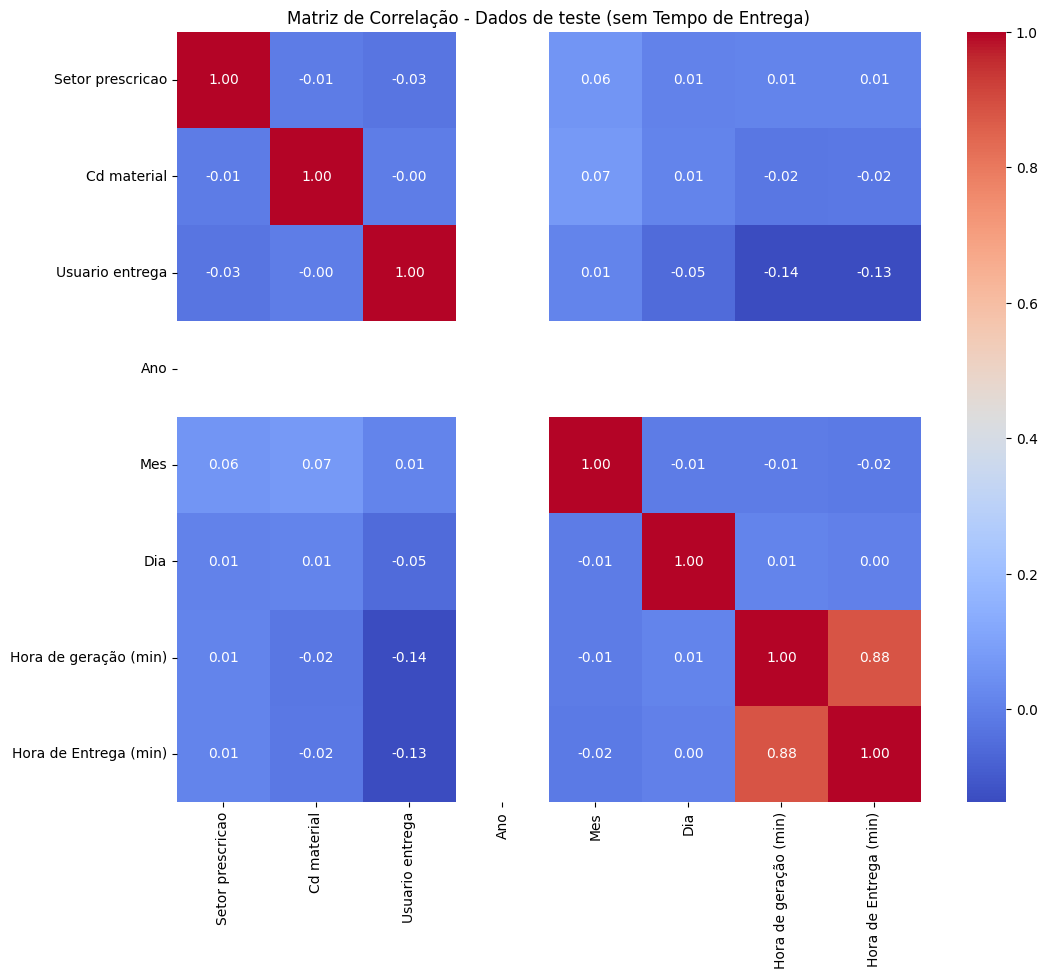

In [ ]:
# @title Criar a matriz de correlação e heat map
correlation_matrix = Tempos_Limpo_Urgencia.corr()

# Remover a coluna 'Tempo de entrega (minutos)'
correlation_matrix = correlation_matrix.drop(['Tempo de entrega (minutos)', 'Tempo de entrega'], axis=0) # Changed this line
correlation_matrix = correlation_matrix.drop(['Tempo de entrega (minutos)', 'Tempo de entrega'], axis=1) # Changed this line

# Criar o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação - Dados de teste (sem Tempo de Entrega)')
plt.show()

# 5 - Choose and Apply a Model and 6 - Refine Your Model

I put the two steps together, as I tested the models already optimizing the hyperparameters for each one. In this phase, I sought to obtain a high R² for validation, as the suggestion is to use the importance of the variables to deepen the critical analysis.

In this step, there are several tests that you can reproduce with your data to find the best model to determine the importance of the variables - Focus on R²

In [ ]:
# @title New Dataframes
#Para faciliar o uso do código original mudei o nome dos dataframes
df = Tempos_Limpo_Urgencia
validacao = Tempos_Limpo_validacao_Urgencia

# 5.1 and 6.1 Random Forest Model

# Validation Results Analysis
After performing model validation (with the validation data), the R² value was negative, indicating a low predictive capacity of the model in relation to the validation data. A negative R² suggests that the model is performing worse than a simple average, which raises concerns about its usefulness for analyzing the importance of variables.

The random forest optimization process was very slow on Google Colab, so I performed the optimization on my personal computer. Below is the image of the result, the code used in item 6.1.2.

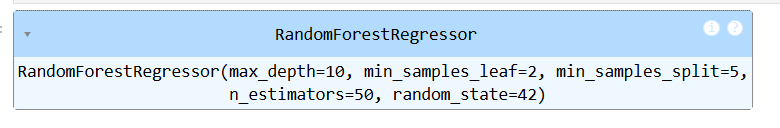

In [ ]:
# @title 5.1.1. Criando Modelo Random Forest
#Definindo quais colunas são as preditoras independentes (X) e qual é a variável dependente (Y)
features = ['Setor prescricao', 'Usuario entrega', 'Dia', 'Hora de geração (min)','Hora de Entrega (min)']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Tempo de entrega (minutos)']

# Separando conjunto de treinamento e teste dentro do modelo.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% para treinamento, 20% para teste

# Criar a random forest com os hiperparâmetros otimizados
rf_model = RandomForestRegressor(n_estimators=50,
                                max_depth=None,
                                min_samples_split=5,
                                min_samples_leaf=2,
                                random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=50,
                      random_state=42)

In [ ]:
# @title 5.1.2. Acurácia e RMSE do modelo Random Forest
# Realizar a validação cruzada e calcular os RMSE scores (usando os próprios dados do modelo)
scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# Calcular o RMSE médio
rmse_medio = rmse_scores.mean()

# Fazer previsões no conjunto de teste e calcular o RMSE do teste
y_pred = rf_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular a acurácia dentro de uma margem de erro (ex: 1 minutos)
margem_erro = 1
acuracia_teste = np.mean(np.abs(y_test - y_pred) <= margem_erro)

# Exibir os resultados usando display()
display(f"RMSE scores: {rmse_scores}")
display(f"RMSE médio: {rmse_medio}")
display(f"RMSE no conjunto de teste: {rmse_test}")
display(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia_teste}")

'RMSE scores: [0.52541204 0.36185835 0.42147993 0.33608191 0.28432316]'

'RMSE médio: 0.3858310789371517'

'RMSE no conjunto de teste: 0.38270409415776546'

'Acurácia (margem de erro = 1 minutos): 0.9959484346224677'

In [ ]:
# @title 6.1.2. Refinando o modelo de Random forest

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criar objeto GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',  # Use a suitable scoring metric
                           n_jobs=-1)  # Use all available CPU cores

# Ajustar GridSearchCV para os dados de treinos
grid_search.fit(X_train, y_train)

# Buscar melhores hiperparametros
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Printar os hiperparametros
print("Best Hyperparameters:", best_params)

In [ ]:
# @title 6.1.3. Testando com dados de validação - R²
# Usando o mesmo features (variáveis independentes - x) e mesmo y.
X_validacao = validacao[features]
y_validacao = validacao['Tempo de entrega (minutos)']

X_validacao = pd.get_dummies(X_validacao, drop_first=True)

y_pred_validacao = rf_model.predict(X_validacao)

rmse_validacao = np.sqrt(mean_squared_error(y_validacao, y_pred_validacao))
r2_validacao = r2_score(y_validacao, y_pred_validacao)

# Calcular acurácia
margem_erro = 1  # Ajuste este valor conforme necessário
acuracia = np.mean(np.abs(y_test - y_pred) <= margem_erro)

display(f"RMSE na validação: {rmse_validacao}")
display(f"R² na validação: {r2_validacao}")
print(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia}")

'RMSE na validação: 3.553996533360885'

'R² na validação: -11.630891359141184'

Acurácia (margem de erro = 1 minutos): 0.9959484346224677


# 5.2 and 6.2 KNeighborsRegressor Model

- Calculated the largest value of k and adjusted it in the model = 1

## Conclusions
- The RMSE is adequate and the R² has a reasonable value, however, KNeighbors does not provide directly interpretable coefficients for the variables - therefore, other models that may be more suitable for the proposal will be explored.

In [ ]:
# @title 5.2.1. KNeighborsRegressor

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo com k vizinhos (ajuste k conforme necessário)
knn_model = KNeighborsRegressor(n_neighbors=1)  # Mudança: usando knn_model como nome da variável

# Treinar o modelo com os dados de treinamento
knn_model.fit(X_train, y_train)  # Mudança: usando knn_model

# Fazer previsões no conjunto de teste
y_pred = knn_model.predict(X_test)  # Mudança: usando knn_model

# Calcular as métricas de desempenho
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calcular a acurácia dentro de uma margem de erro (ex: 1 minutos)
margem_erro = 1  # Ajuste este valor conforme necessário
acuracia = np.mean(np.abs(y_test - y_pred) <= margem_erro)

# Exibir os resultados
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia}")

RMSE: 0.6989933950662706
R²: 0.582342842964986
Acurácia (margem de erro = 1 minutos): 0.9900552486187846


In [ ]:
# @title 6.2.2. Determinando melhor valor de k

# Definir um intervalo de valores para k
param_grid = {'n_neighbors': np.arange(1, 21)}  # Testando de 1 a 20 vizinhos

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Treinar o GridSearchCV com os dados de treinamento
grid_search.fit(X_train, y_train)

# Obter o melhor valor de k
best_k = grid_search.best_params_['n_neighbors']
print(f"Melhor valor de k: {best_k}")

# Criar e treinar o modelo final com o melhor k
knn_model_final = KNeighborsRegressor(n_neighbors=best_k)
knn_model_final.fit(X_train, y_train)

Melhor valor de k: 1


KNeighborsRegressor(n_neighbors=1)

# 5.3 Support Vector Machine Model

Support Vector Regression (SVR) has different kernels available, such as 'linear', 'rbf', 'poly', etc. The linear kernel would not be the most suitable for non-parametric data, and the other kernels are also not expected to perform well in this context. However, to validate this hypothesis, the RBF (Radial Basis Function) kernel was tested.

## Conclusions
- The RMSE is still relatively high and the R² is negative, indicating that the model is not capturing the patterns in the data well and is making poor predictions.
- Due to the complexity of optimizing the C and Epsilon parameters (computational requirements), I did not perform optimization for this model. The negative R² is unlikely to surpass the R² of 0.58 observed in the KNeighbors model.

In [ ]:
# @title 5.3.1. Modelo SVR
# Mesmos dados do modelo de random forest e mesma divisão.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo SVR
svr_model = SVR(kernel='rbf')  # Você pode ajustar o kernel e outros hiperparâmetros aqui

# Treinar o modelo com os dados de treinamento
svr_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = svr_model.predict(X_test)

# Calcular as métricas de desempenho
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calcular acurácia
margem_erro = 1  # Ajuste este valor conforme necessário
acuracia = np.mean(np.abs(y_test - y_pred) <= margem_erro)

# Exibir os resultados
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia}")

RMSE: 1.0873244215560878
R²: -0.010629727709824843
Acurácia (margem de erro = 1 minutos): 0.9755985267034991


# Need to Explore Other Models

- The dataset used already has an adequate structure, with well-defined and sufficiently informative variables. No problems were identified, such as redundancy, low quality, or lack of explanatory variables that would justify the creation of new derived features.
- The use of the KNeighbors model, combined with cross-validation and hyperparameter optimization, demonstrated that performance is not limited by existing features, but rather by the model's ability to capture complex relationships between variables.
- The size of the dataset (50 thousand samples for the model and 20 thousand for the test) is sufficient to ensure robustness in the analyses, with no significant impact when increasing the number of samples. Thus, the focus is on exploring models that are more interpretable or suitable for the proposal.

Therefore, there is no evidence that feature engineering is a solution to improve the performance or interpretability of the model. The main challenge now is to test more robust models that can determine the importance of variables with greater precision.

# 5.4 and 6.4 Models with Boosting Technique:

XGBoost, LightGBM, and CatBoost are decision tree-based machine learning algorithms that use the boosting technique, offer high performance and scalability, include regularization to prevent overfitting, provide variable importance measures, and support parallelization.
These models are excellent for determining the importance of variables. These algorithms provide variable importance measures, which help identify which features have the greatest impact on model predictions.

The following models will be tested:
- XGBoost
- Light GBM
- CATBoost

## XGBoost:

- Validation RMSE: 0.31055948519876303
- Validation R²: 0.8616874604931072
- Accuracy (margin of error = 1 minute): 0.9873534286942108

#### Analysis: The XGBoost model shows good performance in terms of RMSE and accuracy, with values that indicate high precision in predictions. The validation R² is approximately 0.8617. This shows that XGBoost not only has accuracy in predictions but also captures the variability of the process well.

## Light GBM:

- Validation RMSE: 0.32091729791589985
- Validation R²: 0.8523075779280891
- Accuracy (margin of error = 1 minute): 0.9880287310454908

#### Analysis: The LightGBM model stands out with a significantly high R² (0.8523), indicating that it is efficient in capturing the variability of the process. Although the RMSE is slightly higher compared to XGBoost, the high R² suggests that the model is better at explaining the importance of variables. Furthermore, the accuracy of 98.80% within a margin of error of 1 minute reinforces its prediction accuracy.

## CATBoost:

- Validation RMSE: 0.4328326445194679
- Validation R²: 0.731334454172895
- Accuracy (margin of error = 1 minute): 0.9844680459205599

#### Analysis: CATBoost shows reasonable performance in terms of RMSE and accuracy, with an RMSE of approximately 0.4328. The validation R² is approximately 0.7313.

# 6.5 Model Selection
Both LightGBM and XGBoost had a good prediction of the importance of variables for the variation in delivery time due to their high R² value in validation (approximately 0.85). This means that both are able to explain a large part of the process variability, making them suitable for identifying which variables have the greatest impact on delivery time.

Despite LightGBM's RMSE being slightly higher compared to XGBoost, LightGBM's ability to capture the importance of variables justifies its choice for this application. Furthermore, LightGBM offers advantages in terms of efficiency, scalability, and ease of implementation. These characteristics make LightGBM a solid choice, even though XGBoost performs slightly better in validation results.

# 6.6 Refinement of the Chosen Model - LightGBM.

Comment - As model optimization with decision tree-based machine learning algorithms that use the boosting technique is time-consuming, I chose to compare the models before optimization and optimize only the chosen model. (As it should have been from the beginning, but I thought optimizing the models while I was producing would be a viable strategy).


### Results Before Optimization:
- Validation RMSE: 0.32091729791589985
- Validation R²: 0.8523075779280891
- Accuracy (margin of error = 1 minute): 0.9880287310454908

### Results After Optimization:
- Validation RMSE: 0.15128138674961475
- Validation R²: 0.9671796692902308
- Accuracy (margin of error = 1 minute): 0.9972373994720364

Optimizing the hyperparameters of the LightGBM model resulted in a significant improvement in all aspects of performance. The RMSE was reduced from 0.32 to 0.15, indicating much greater accuracy in predictions. The R² increased from 0.85 to 0.97. Furthermore, the accuracy within a margin of error of 1 minute improved from 98.80% to 99.72%.

These results demonstrate the effectiveness of hyperparameter optimization in improving the performance of the LightGBM model.

In [ ]:
# @title 5.4.1 XGBoost
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb

# 1. Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Crie o modelo GBM (XGBoost) com parâmetros robustos
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Função de perda para regressão
    n_estimators=100,            # Número de árvores de decisão
    max_depth=3,                 # Profundidade máxima das árvores
    learning_rate=0.1,           # Taxa de aprendizado
    subsample=0.8,              # Subamostragem de linhas
    colsample_bytree=0.8,        # Subamostragem de colunas
    reg_alpha=0.1,               # Regularização L1 (Lasso)
    reg_lambda=0.1,              # Regularização L2 (Ridge)
    random_state=42              # Semente aleatória para reprodutibilidade
)

# 3. Ajuste o modelo aos dados de treinamento
xgb_model.fit(X_train, y_train)

# Realizar a validação cruzada e calcular os RMSE scores (usando os próprios dados do modelo)
scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# Calcular o RMSE médio
rmse_medio = rmse_scores.mean()

# Fazer previsões no conjunto de teste e calcular o RMSE do teste
y_pred = rf_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular a acurácia dentro de uma margem de erro (ex: 1 minutos)
margem_erro = 1
acuracia_teste = np.mean(np.abs(y_test - y_pred) <= margem_erro)

# Exibir os resultados usando display()
display(f"RMSE scores: {rmse_scores}")
display(f"RMSE médio: {rmse_medio}")
display(f"RMSE no conjunto de teste: {rmse_test}")
display(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia_teste}")

'RMSE scores: [0.52541204 0.36185835 0.42147993 0.33608191 0.28432316]'

'RMSE médio: 0.3858310789371517'

'RMSE no conjunto de teste: 0.38270409415776546'

'Acurácia (margem de erro = 1 minutos): 0.9959484346224677'

In [ ]:
# @title 6.4.1 XGBoost Validation

# 1. Divisão dos dados (treinamento, teste e validação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_validacao, y_train, y_validacao = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 2. Fazer previsões no conjunto de validação usando o modelo XGBoost
y_pred_validacao = xgb_model.predict(X_validacao)  # Usando xgb_model em vez de rf_model

# 3. Calcular as métricas de avaliação
rmse_validacao = np.sqrt(mean_squared_error(y_validacao, y_pred_validacao))
r2_validacao = r2_score(y_validacao, y_pred_validacao)

# Calcular acurácia (usando o conjunto de teste)
margem_erro = 1  # Ajuste este valor conforme necessário
y_pred = xgb_model.predict(X_test) # Usando xgb_model para previsões no conjunto de teste
acuracia = np.mean(np.abs(y_test - y_pred) <= margem_erro)

# 4. Exibir os resultados
display(f"RMSE na validação: {rmse_validacao}")
display(f"R² na validação: {r2_validacao}")
print(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia}")

'RMSE na validação: 0.31055948519876303'

'R² na validação: 0.8616874604931072'

Acurácia (margem de erro = 1 minutos): 0.9873534286942108


In [ ]:
# @title 5.4.2 LightGBM

# 1. Divisão dos dados (treinamento, teste e validação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_validacao, y_train, y_validacao = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 2. Crie o modelo LightGBM com parâmetros robustos
lgb_model = lgb.LGBMRegressor(
    objective='regression',  # Função de perda para regressão
    n_estimators=100,         # Número de árvores de decisão
    max_depth=10,              # Profundidade máxima das árvores
    learning_rate=0.1,        # Taxa de aprendizado
    subsample=0.8,           # Subamostragem de linhas
    colsample_bytree=0.8,     # Subamostragem de colunas
    reg_alpha=0.1,            # Regularização L1 (Lasso)
    reg_lambda=0.1,           # Regularização L2 (Ridge)
    random_state=42           # Semente aleatória para reprodutibilidade
)

# 3. Ajuste o modelo aos dados de treinamento
lgb_model.fit(X_train, y_train)

# 4. Fazer previsões no conjunto de validação usando o modelo LightGBM
y_pred_validacao = lgb_model.predict(X_validacao)

# 5. Calcular as métricas de avaliação
rmse_validacao = np.sqrt(mean_squared_error(y_validacao, y_pred_validacao))
r2_validacao = r2_score(y_validacao, y_pred_validacao)

# Calcular acurácia (usando o conjunto de teste)
margem_erro = 1  # Ajuste este valor conforme necessário
y_pred = lgb_model.predict(X_test) # Usando lgb_model para previsões no conjunto de teste
acuracia = np.mean(np.abs(y_test - y_pred) <= margem_erro)

# 6. Exibir os resultados
display(f"RMSE na validação: {rmse_validacao}")
display(f"R² na validação: {r2_validacao}")
print(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 30405, number of used features: 5
[LightGBM] [Info] Start training from score 0.000274


'RMSE na validação: 0.20602312810685183'

'R² na validação: 0.9391299143489804'

Acurácia (margem de erro = 1 minutos): 0.9934925409785745


In [ ]:
# @title 6.4.2 LightGBM - Otimization.
# Define o espaço de busca de hiperparâmetros para o LightGBM
param_dist = {
    'n_estimators': randint(100, 500),  # Número de árvores
    'learning_rate': uniform(0.01, 0.3),  # Taxa de aprendizado
    'num_leaves': randint(20, 100),  # Número máximo de folhas por árvore
    'max_depth': randint(3, 10),  # Profundidade máxima das árvores
    'min_child_samples': randint(10, 50),  # Número mínimo de amostras por folha
    'subsample': uniform(0.5, 0.5), # Subamostragem de linhas
    'colsample_bytree': uniform(0.5, 0.5), # Subamostragem de colunas
    'reg_alpha': uniform(0, 1), # Regularização L1
    'reg_lambda': uniform(0, 1)  # Regularização L2
}

# Cria o modelo LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Cria o objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Número de iterações de busca aleatória (ajuste conforme necessário)
    cv=5,  # Número de folds para validação cruzada
    scoring='neg_root_mean_squared_error',  # Métrica de avaliação
    n_jobs=-1,  # Usa todos os núcleos do processador
    verbose=2,  # Mostra o progresso da busca
    random_state=42 # Define uma semente para reprodutibilidade
)

# Executa a busca aleatória de hiperparâmetros
random_search.fit(X_train, y_train)

# Obtém o melhor modelo e os melhores hiperparâmetros
best_lgb_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Melhores hiperparâmetros:", best_params)

# Avalia o melhor modelo no conjunto de validação
y_pred_validacao = best_lgb_model.predict(X_validacao)
rmse_validacao = np.sqrt(mean_squared_error(y_validacao, y_pred_validacao))
r2_validacao = r2_score(y_validacao, y_pred_validacao)

# Calcula a acurácia no conjunto de teste
y_pred = best_lgb_model.predict(X_test)
acuracia = np.mean(np.abs(y_test - y_pred) <= margem_erro)

# Exibe os resultados
print(f"RMSE na validação: {rmse_validacao}")
print(f"R² na validação: {r2_validacao}")
print(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 30405, number of used features: 5
[LightGBM] [Info] Start training from score 0.000274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [ ]:
# @title 5.4.3 e 6.4.3 CatBoost

# 1. Divisão dos dados (treinamento, teste e validação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_validacao, y_train, y_validacao = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 2. Crie o modelo CatBoost com parâmetros robustos
catboost_model = CatBoostRegressor(
    iterations=100,              # Número de árvores de decisão
    learning_rate=0.1,           # Taxa de aprendizado
    depth=3,                    # Profundidade máxima das árvores
    l2_leaf_reg=0.1,            # Regularização L2 (Ridge)
    random_strength=0.8,         # Força aleatória para splits
    loss_function='RMSE',        # Função de perda (RMSE)
    verbose=False,                # Suprimir saída detalhada
    random_state=42              # Semente aleatória para reprodutibilidade
)


# 3. Ajuste o modelo aos dados de treinamento
catboost_model.fit(X_train, y_train)

# 4. Fazer previsões no conjunto de validação usando o modelo CatBoost
y_pred_validacao = catboost_model.predict(X_validacao)

# 5. Calcular as métricas de avaliação
rmse_validacao = np.sqrt(mean_squared_error(y_validacao, y_pred_validacao))
r2_validacao = r2_score(y_validacao, y_pred_validacao)

# Calcular acurácia (usando o conjunto de teste)
margem_erro = 1  # Ajuste este valor conforme necessário
y_pred = catboost_model.predict(X_test)
acuracia = np.mean(np.abs(y_test - y_pred) <= margem_erro)

# 6. Exibir os resultados
display(f"RMSE na validação: {rmse_validacao}")
display(f"R² na validação: {r2_validacao}")
print(f"Acurácia (margem de erro = {margem_erro} minutos): {acuracia}")

'RMSE na validação: 0.4328326445194679'

'R² na validação: 0.731334454172895'

Acurácia (margem de erro = 1 minutos): 0.9844680459205599


# 7.1 – Conclusion
- Gradient Boosting Machines (GBM): LightGBM. This model combines multiple decision trees, but sequentially, giving more weight to incorrectly classified data points. With this model, it was possible to achieve the parameters (after hyperparameter optimization):
- 'Validation RMSE: 0.15128138674961475'
- 'Validation R²: 0.9671796692902308'
- Accuracy (margin of error = 1 minute): 0.9972373994720364

# Proposal for Daily Use
The proposed model aims to determine the importance of each variable in the variation of the process. This model will be applied monthly, and the importance of the variables should be compared with the variation in delivery time (IQR, Median, and Deliveries under 30 minutes).

## Integration with Gradient Boosting Machines (GBM)
We will use GBM to identify the importance of each feature. The features used in GBM include:
- Prescribing Sector
- Delivery User
- Day
- Generation Time (minutes)
- Delivery Time (minutes)

## Analysis and Action
After evaluating the importance of each variable, a root cause analysis (5 whys) will be conducted with the Gemba. The first question will be something like: "Our delivery time improved this month and Delivery Time had a greater importance compared to last month, why?"

## Advantages of the Proposed Model
- Continuous Improvement: With the monthly application, it will be possible to identify and act on the variables that most influence delivery time, promoting a continuous improvement cycle.
- Detailed Analysis: Using GBM to determine the importance of variables allows for a detailed analysis of each influential factor in the process.
- Operational Efficiency: By understanding which variables impact delivery time the most, resources and processes can be optimized, resulting in greater operational efficiency.
- Informed Decisions: Root cause analysis (5 whys) facilitates informed and data-driven decision-making, providing more effective and targeted solutions.
- Proactiveness: With the prior identification of influential variables, it is possible to anticipate problems and act preventively to avoid them.

**Note:** This model should be used in conjunction with other analyses such as EWMA of the 75th percentile for delivery time or other analyses relevant to the importance of variables.

# 7.2 Model in Practice

- 7.2.1 - A process performance indicator was created to assess in which months there was greater or lesser performance. The indicator takes into account the variables - '% of deliveries above 30 minutes', 'Median', 'Percentile 0.9', '% Outliers (Q3 + 5*IQR)'.
- 7.2.2 - The importance of the variables was determined month by month and evaluated to obtain insights.
- 7.3.2 - Daily delivery evaluation is performed based on the quantity and delivery time per hour, using visualizations in Power BI (image below), while the monthly analysis applies the third percentile with EWMA to identify patterns (illustrative code with validation data below).

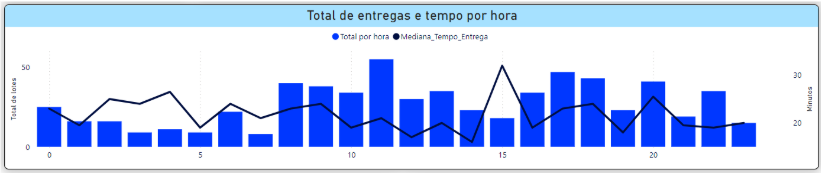

# 7.3 - Critical Analysis

When evaluating the importance of variables in a LightGBM model, all showed relative stability, except for the variable "batch delivery time," which stood out significantly. This result shows that the delivery time has a relevant impact on the overall delivery time, being one of the main factors associated with the increase or reduction of this indicator. The greater the importance attributed to this variable by the model, the greater its negative influence on performance. Therefore, monitoring delivery times is crucial for more accurate and effective process monitoring. Before this insight, efforts were focused on delivery sectors and users, approaches that generated limited results.

This visibility helped create a more suitable indicator panel to identify at which peaks delivery time is most concerning. When comparing May (worst performance) with October (best performance), the delivery profile remains similar. Deliveries near 4 am are slower due to the pharmacy's terminal cleaning at that time, and deliveries near 7 pm are slower, coinciding with the delivery of non-urgent medications and the messengers' coffee break.

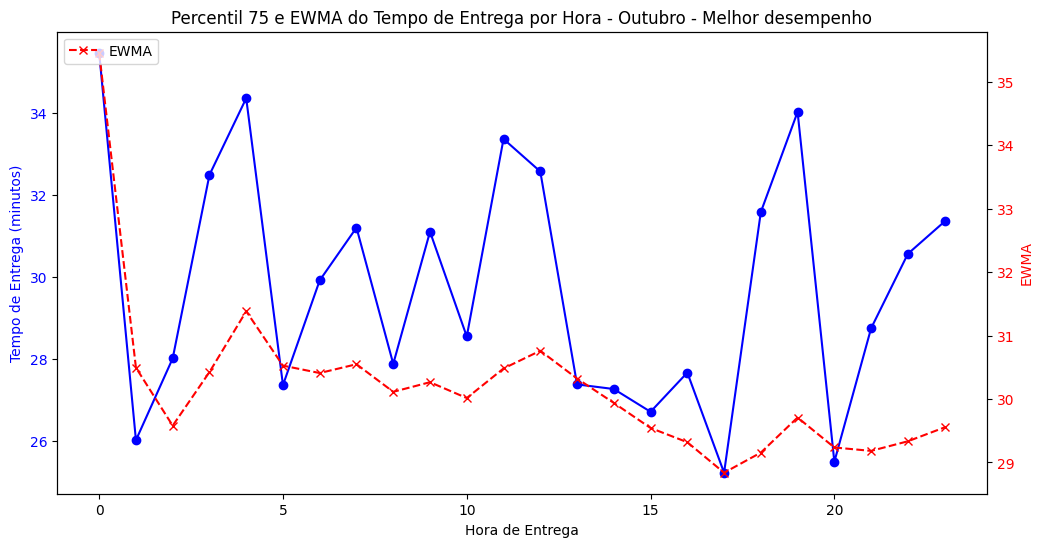

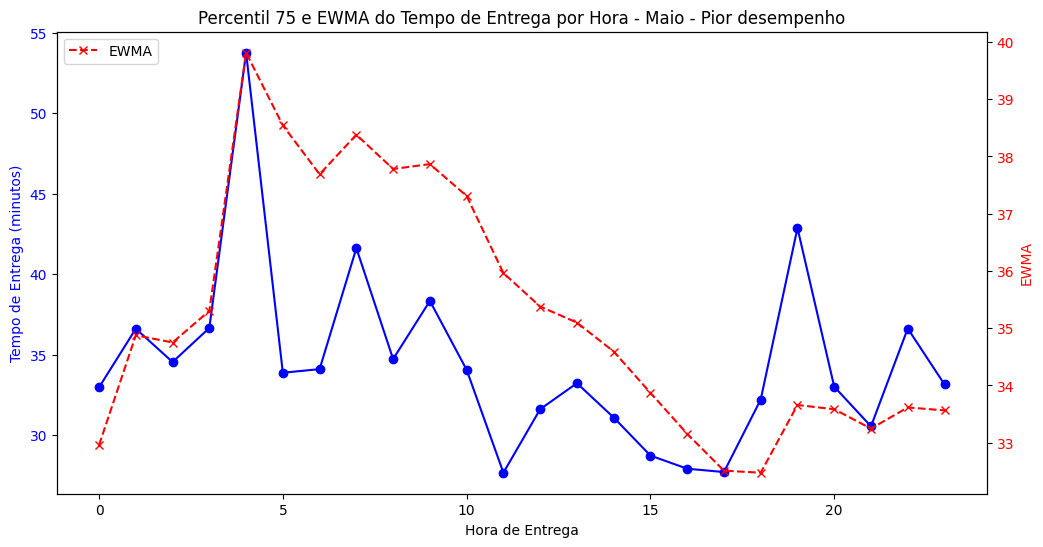

Despite these two peaks, in the month with the best performance, the EWMA was lower at all times when compared to the month with the worst performance (graphs below). During peak hours in the best-performing month, the target was exceeded by 4 minutes in the slowest deliveries but remained within the target at other times. In contrast, in the worst-performing month, deliveries were above the target at all times, with worse performance in the morning. This indicates that the morning shift should be prioritized for a root cause discussion about longer delivery times.

For the future, the monthly comparison of variables will allow us to understand how each variation, however small, can positively or negatively impact delivery time. The initial focus will be on morning hours unless another variable shows a significant variation in importance, justifying a change in strategy.

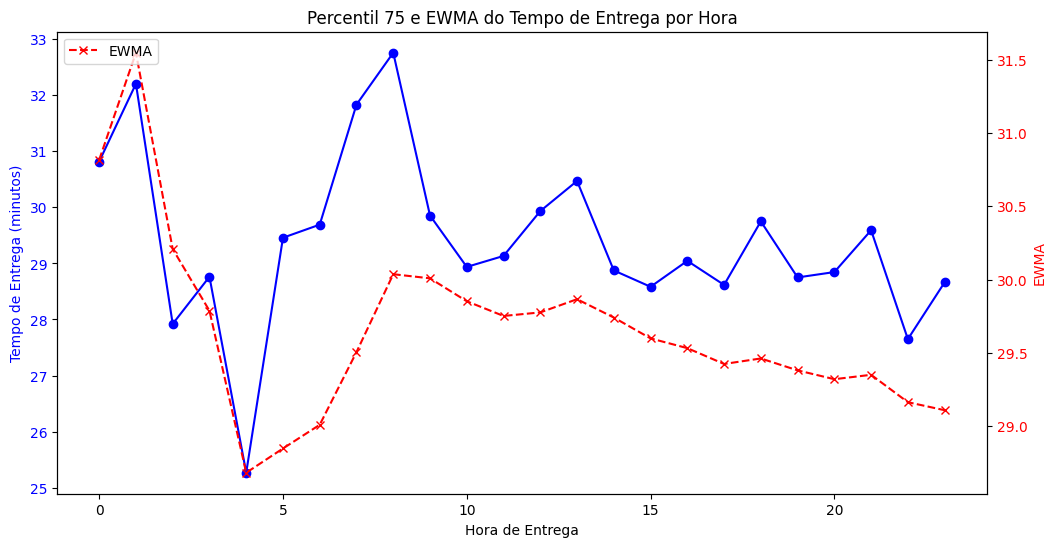

In [ ]:
# @title Percentile 75 + EWMA - Hourly

# Agrupar por hora de entrega e calcular o percentil 75
tempos_por_hora = Tempos_Limpo_validacao_Urgencia1.groupby(Tempos_Limpo_Urgencia['Hora de Entrega'].dt.components.hours)['Tempo de entrega (minutos)'].quantile(0.75)

# Calcular a EWMA com um fator de suavização de 0.1
ewma = tempos_por_hora.ewm(alpha=0.1).mean()

# Criar o gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotar o percentil 75
ax1.plot(tempos_por_hora.index, tempos_por_hora.values, marker='o', linestyle='-', color='blue', label='Percentil 75')
ax1.set_xlabel('Hora de Entrega')
ax1.set_ylabel('Tempo de Entrega (minutos)', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Criar um segundo eixo y para a EWMA
ax2 = ax1.twinx()
ax2.plot(ewma.index, ewma.values, marker='x', linestyle='--', color='red', label='EWMA')
ax2.set_ylabel('EWMA', color='red')
ax2.tick_params('y', labelcolor='red')

# Adicionar título e legenda
plt.title('Percentil 75 e EWMA do Tempo de Entrega por Hora')
plt.legend(loc='upper left')

# Exibir o gráfico
plt.show()

In [ ]:
# @title Process Performance Indicator

#Importação dos dados
tipos_dados = {
    'Mês': str,
    'Mediana': str,
    'Percentil 0,9': float,
    '% de entregas acima de 30 minutos': float,
    '% Outliers (Q3 + 5*IQR)': float
}

# Função para remover o % e converter para float
def converter_porcentagem(valor):
    try:
        return float(valor.rstrip('%').replace(',', '.')) / 100  # Remove %, replace , with . and divide by 100
    except AttributeError:
        return valor  # Retorna o valor original se não for string

# Leitura da base de dados:
Indicador_desempenho = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projeto ciência de dados 2/Dados para indicador de desempenho.csv', decimal=',', converters={'% de entregas acima de 30 minutos': converter_porcentagem, '% Outliers (Q3 + 5*IQR)': converter_porcentagem})
Indicador_desempenho = Indicador_desempenho.rename(columns={Indicador_desempenho.columns[0]: 'Mês'})

# Converte a coluna 'Mediana' para formato de minutos (float)
Indicador_desempenho['Mediana'] = pd.to_timedelta(Indicador_desempenho['Mediana']).dt.total_seconds() / 60

#Definindo Pesos
pesos = {
    '% de entregas acima de 30 minutos': 0.5,
    'Mediana': 0.2,
    'Percentil 0,9': 0.15,
    '% Outliers (Q3 + 5*IQR)': 0.15
}

for indicador in pesos.keys():
    # Checar se o peso está ignorando a coluna mês (houve um problema com esse modelo)
    if indicador == 'Mês':
        continue

    # Converter as colunas para numérico (acabei salvando o arquivo base sem configurar adequadamente)
    if Indicador_desempenho[indicador].dtype == object:
        Indicador_desempenho[indicador] = pd.to_numeric(Indicador_desempenho[indicador], errors='coerce')

    # Inverter a configuração do indicador, pois, a metrica é "quanto menor - melhor"
    if indicador in ['Mediana', 'Percentil 0,9', '% de entregas acima de 30 minutos', '% Outliers (Q3 + 5*IQR)']:
        Indicador_desempenho[indicador + '_normalizado'] = 1 - (Indicador_desempenho[indicador] - Indicador_desempenho[indicador].min()) / (Indicador_desempenho[indicador].max() - Indicador_desempenho[indicador].min())
    else:
        Indicador_desempenho[indicador + '_normalizado'] = (Indicador_desempenho[indicador] - Indicador_desempenho[indicador].min()) / (Indicador_desempenho[indicador].max() - Indicador_desempenho[indicador].min())

Indicador_desempenho['Pontuação'] = 0
for indicador, peso in pesos.items():
    Indicador_desempenho['Pontuação'] += Indicador_desempenho[indicador + '_normalizado'] * peso

Indicador_desempenho = Indicador_desempenho.sort_values(by=['Pontuação'], ascending=False)

# (acabei salvando o arquivo base sem configurar adequadamente)
Indicador_desempenho['Mês'] = Indicador_desempenho['Mês'].str.capitalize()

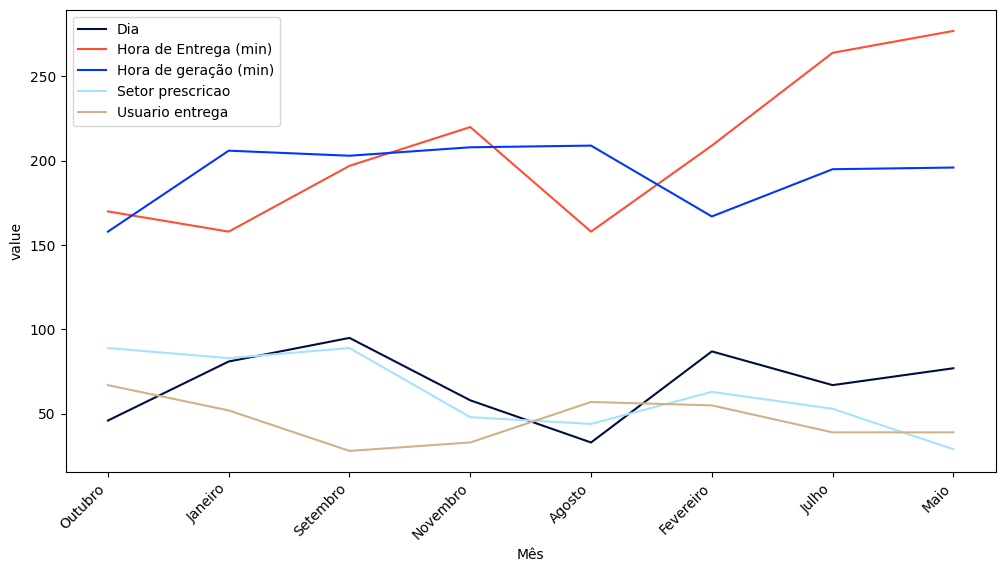

In [ ]:
# @title Analysis of Variable Importance According to Process Performance
# Os valores de abril estavam corrompidos - retirei dessa análise.
# Os valores de Março estavam inconsistentes, removi da análise.

# Ler o arquivo base - foi necessário usar o transpose, pois, a tabela não estava no formato adequado.
Indicador_desempenho1 = pd.read_csv('/content/drive/MyDrive/Projeto ciência de dados II/Importancia das variáveis - Mês a Mês.csv', header=0).transpose()

# Renomear a primeira coluna
Indicador_desempenho1.columns = Indicador_desempenho1.iloc[0]
Indicador_desempenho1 = Indicador_desempenho1[1:]

# Ajustar o indice para 'Mês'
Indicador_desempenho1 = Indicador_desempenho1.reset_index()
Indicador_desempenho1 = Indicador_desempenho1.rename(columns={'index': 'Mês'})

# Ajusta a coluna 'Mês' do Indicador_desempenho1 para começar com letra maiúscula
Indicador_desempenho1['Mês'] = Indicador_desempenho1['Mês'].str.capitalize()

# Merge Indicador_desempenho1 and Indicador_desempenho to add the 'Pontuação' column
Indicador_desempenho1 = pd.merge(Indicador_desempenho1, Indicador_desempenho[['Mês', 'Pontuação']], on='Mês', how='left')

Indicador_desempenho1 = Indicador_desempenho1.sort_values(by=['Pontuação'], ascending=False)

# Remove março do Indicador_desempenho
Indicador_desempenho = Indicador_desempenho[Indicador_desempenho['Mês'] != 'Março']

# Remove março do Indicador_desempenho1
Indicador_desempenho1 = Indicador_desempenho1[Indicador_desempenho1['Mês'] != 'Março']

# Seleciona as colunas desejadas para o gráfico
cols_to_plot = ['Dia', 'Hora de Entrega (min)', 'Hora de geração (min)', 'Setor prescricao', 'Usuario entrega']

cores_personalizadas = {
    'Dia': '#000e40',
    'Hora de Entrega (min)': '#ff4e33',
    'Hora de geração (min)': '#0037ff',
    'Setor prescricao': '#a6e1ff',
    'Usuario entrega': '#d1b287'
}
# Ajustado a ordem conforme a pontuação de desempenho
plt.figure(figsize=(12, 6))
sns.lineplot(x='Mês', y='value', hue='variable',
             data=pd.melt(Indicador_desempenho1[['Mês'] + cols_to_plot], ['Mês']),
             palette=cores_personalizadas)
plt.xticks(rotation=45, ha='right')
plt.legend(title="")
plt.show()

# 8. Project Results

With the successful implementation of this project, I present a compilation of the results and lessons learned over time. This project has brought significant improvements and transformed our approach to indicator analysis, providing valuable insights and more efficient process management.

# Learning and Improvements

### Efficiency
The evolution of this indicator allowed for greater efficiency in analysis and evidence-based decision-making. The time to produce the indicator was drastically reduced.

### Proximity to the Gemba Team
Due to the increased effectiveness in the daily analysis of the indicator, greater proximity of coordination in daily actions was possible.

### Data-Driven Thinking
With the evolution of this indicator, the entire team bases their daily decisions focused on direct impact on the indicator. For example, changing rest breaks according to delivery peaks.

### Daily Discussions
The messenger team naturally began to discuss strategies daily to reduce delivery time and focused on learning what was impacting the robustness of the process the most.

### Reduction in the 90th Percentile and Percentage of Items Delivered Above 30 Minutes
Compared to the first half of 2024, the 90th percentile decreased by 4 minutes (from 44 to 40 minutes); and the percentage of items delivered in less than 30 minutes increased by 6% (from 70% to 76%).